# **ETPoF** Homework 3
Annemarie Linnenbank & Tommie Verouden

*22 March 2024*

In [2]:
# Ensure the module is automatically reloaded when rerunning the import command.
%load_ext autoreload
%autoreload 2

In [3]:
import etpof
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from tqdm import tqdm

## Particle Tracking (25 points)
### 1) **Calibration** (3 pts)

We start by illustrating the calibration of camera a). Below it, we outline 
the steps taken to obtain these results. The functions used can be found in `functions1.py`, which is part of the `etpof` module, added as an appendix below.

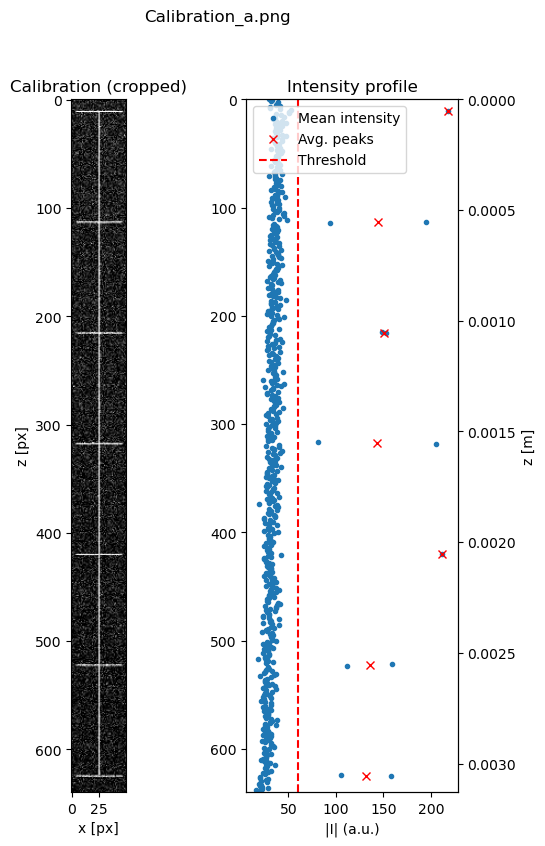

In [4]:
directory = 'PTV'
roi_calib = [200, 250, 30, 670]
calib_dist = 0.5 # [m]
threshold = 60

_, _, _, = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold,
                                   peak_method='weighted_avg',
                                   file_prefix='Calibration_', 
                                   plot=[True, False], verbose=False,
                                   precision=7, units='m')


For each camera, we go through the following calibration steps:
1. We import the (grayscale) calibration image and manually inspect it to determine a suitable region of interest (ROI), containing the calibration pattern, but not the scale numbers and as little background noise as possible.
2. We assume that the background noise is the same throughout the image, and 
that the horizontal lines are, in fact, horizontal. _On closer inspection, the vertical line connecting the calibration lines has no angle: it follows a single pixel column._
3. These two assumptions allow us to average the pixel values in the ROI in the horizontal direction to obtain a 1D "intensity profile" of the calibration image.
4. We then calculate the subpixel position of the peaks in the intensity 
profile by taking the average $z$ coordinate of all values around each peak that are larger than a set threshold. In the plot, these are the points to the right of the red dashed line. In calculating the average, we weigh each row by its intensity value. _Note that we could have also used fitted a Gaussian or 
another function to determine the exact peak, but this method already 
resulted in such a small error, and it did not seem to make much sense to fit a function to the 1 or 2 data points making up each peak._
5. Like in the previous homework assignment, we calculate all possible 
distances between the peaks (i.e., from the top line to the second one, one 
to three, one to four, etc.) and get a resolution value corresponding to each line-line combination by dividing between the distance in "real space". This distance is given by the calibration distance divided by the number of lines separating the two peaks.
6. Finally, we average the resolution values, weighted by the distance in 
real space, to obtain the final resolution value. This way, the longer distances, which contain a smaller error, weigh more heavily. The (weighted) standard deviation of the set of resolution values then gives us a measure of the error in the calibration.

Besides the resolution value, we also obtain an offset value, given by the average difference in position of the seven lines between the images of camera b) and a). This offset will later be used to align the images of the cameras.

In [5]:
res_avg, res_std, offset\
    = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold)

print(f'\nResolution difference across the image: '
      f'{(abs(res_std[1] - res_std[0]) * 860 * 1000):.2f} mm.')

==> Calibration_a.png:
The average resolution is 0.0048892 m/px,
with a standard deviation of 0.0000018 m/px (0.038 %).
==> Calibration_b.png:
The average resolution is 0.0048895 m/px,
with a standard deviation of 0.0000017 m/px (0.034 %).
The offfset is -0.0000494 m.

Resolution difference across the image: 0.13 mm.


The results of the calibration are shown above, and are very similar for the 
two cameras at $4.89$ $\rm{mm/px}$. The standard error is also very similar, at $2$ $\rm{\mu m/px}$. The difference in resolution between the two cameras can only account for a total error of about $0.13$ $\rm{mm}$ across the entire height of the images of about 0.13 mm.
 
In the next parts, we will use the resolution values corresponding to the camera with which the image was taken, and apply the offset (about to the coordinates in camera b). 

### 2) **Particle detection** (3 pts)

For detecting the particles, we have written the following algorithm. To be 
subpixel-accurate, we have tried to perform the least possible number of destructive operations. The functions used can be found in `functions2.py`, which is also part of the `etpof` module in the appendix. The steps below are performed on each image separately.

#### 1. Pre-processing
- We start by reading the image file and pre-processing the image. The goal 
here is to remove the (noisy) background while keeping the greyscale values of the particles intact.
- We apply a bilateral filter to the image to remove noise while keeping the 
edges sharp. This filter works by replacing the intensity of each pixel with a (Gaussian) weighted average of the intensities of nearby pixels. However, for each nearby pixel, the difference in (color) intensity is also taken into account using another (Gaussian) kernel. Therefore, we supply the filter with two kernel sizes. These values are determined empirically, and we have found that the filter works well with a larger colour kernel size than the spatial kernel size.
- A second bilateral filter with smaller kernel sizes is applied to remove finer details in the image.
- Remaining dim pixels and rough edges around the particles are removed by applying a threshold operation that sets pixels below a certain intensity to zero.
- We further clean up the background by using a hit-or-miss filter to remove horizontal or vertical stripes that do not have any (diagonal) neighbours. This works well to prevent false positives later on.

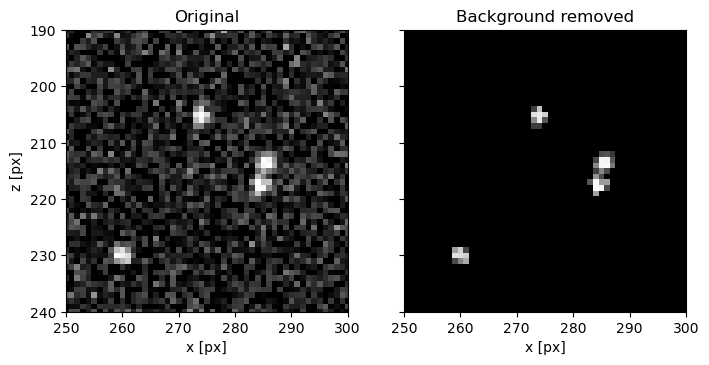

In [6]:
# Remove background from an example image
test_image = etpof.read_image('PTV/a1.png')
processed_image = etpof.remove_background(test_image)

# Plot a part of the original and processed image
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(test_image, cmap='gray')
ax[0].set_xlim([250, 300])
ax[0].set_ylim([240, 190])
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('z [px]')
ax[0].set_title('Original')
ax[1].imshow(processed_image, cmap='gray')
ax[1].set_xlim([250, 300])
ax[1].set_ylim([240, 190])
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
ax[1].set_title('Background removed')
plt.show()


As can be seen, we are left with just the particles, and their details are 
still intact (albeit slightly dimmer). From this processed image, we extract 
the contours of the particles, and filter out contours with a too small area.

#### 2. Finding the particle centres
For each contour, we will be following the steps below to find the particle 
centre contained within it with subpixel accuracy. For this we use two 
versions of the image: one "background-less", where every pixel that is not  
part of this contour is set to zero, and one "isolated", where the contour 
and surrounding background pixels are kept, but all other contours are made 
black.
- We find the rectangular bounding box of the contour (with a margin) and 
find any local maxima in the "background-less" image within this box. Maxima 
with an intensity below a certain threshold are discarded, since stray pixels
 at the edges of the particles turned out to be a problem. If this gives no 
 results, the contour will be discarded; it must have been a false
 positive. Note that the maxima resulting from this calculation are 
 often clustered in groups of multiple pixels with the same high intensity.
 - There are many cases in which two particles together are seen as one 
 single contour. Therefore, we continue by splitting groups of maxima into 
 clusters. We do this by generating a matrix with the distance between all 
 maxima. By checking which entries in each column are below a given distance 
 threshold, we can determine which pixels are actually "connected". We then 
 remove any combinations that are simply a subset of a larger cluster (after 
 all, maximum #2 might be close to maximum #1 and maximum #3, but that does 
 not mean that #1 will show up as a neighbour of #3). This leaves us with 
 clustered groups of maxima.
  - Next, we consider each cluster separately. When a cluster consists of 
  multiple pixels, we reduce that to a single (integer pixel) coordinate by 
  applying a small Gaussian blur - this time to the "isolated" image, as to 
  also take the edges (that might have been marked as part of the background) 
  into account. The local maxima of the blurred image are found, rejecting 
  any that are not close to the original cluster. This process of "destroying 
  neighbours" is repeated until one maximum comes out of the algorithm. However,
   an exception is made for the rare occasions when the blur accidentally 
   causes there to be no maximum anymore, in which case the first maximum of 
   the original cluster is simply taken (this part of the algorithm could be 
   improved upon). To prevent this while loop from running indefinitely, we 
   also set a maximum number of iterations.

#### 3. Subpixel accuracy
Now that we have identified a single pixel that serves as the local 
 maximum of each cluster within the contour, it is time to move towards 
 subpixel accuracy. The main part of this calculation is to fit two Gaussian 
 functions to the "isolated" box, centred on (and with the height of) the local 
 maximum - in the $x$ (or $y$) and $z$ direction, respectively. The size of 
 cluster before destroying the neighbours is used as initial guess for the standard 
deviation of the Gaussian. However, for a contour with a double peak, this 
causes a problem: the other peak might interfere. In order to determine 
which pixels to use for this fitting operation, we calculate the bisector at
the midpoint between the maximum of the current cluster and the maxima of 
the other cluster(s). The pixels on the "opposite" side of the bisector are
blacked out, and the Gaussians are fitted to the remaining pixels. Any failed fits are rejected (which might be the cause of any false negatives).
Note that all parts of the algorithm are robust for clusters containing three
 or more maxima too.

The coordinates are saved, and the standard errors in the fit are provided as uncertainty of the coordinates, although at the moment, we did not get to utilise these values. Finally, the process is repeated for the next cluster, contour and image. An example of a complicated case is shown below.

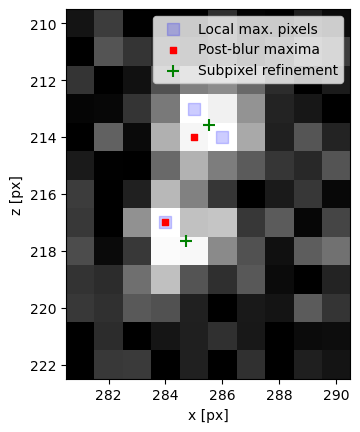

In [7]:
# Find the contours in the example
contours, _ = cv.findContours(processed_image, cv.RETR_EXTERNAL,
                              cv.CHAIN_APPROX_SIMPLE)

_ = etpof.find_particle_center(test_image, contours, 15, plot_all=True)

The results for camera a and b are shown below.

In [8]:
# For camera a
coordsA, intensitiesA, coords_errA, intensities_errA, particles_foundA \
    = etpof.analyze_camera('PTV', 'a', res_avg[0], offset[0],
                           min_contour_area=1, min_intensity=200, 
                           neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, 
                           plot_particles=False)

Processing images: 100%|██████████| 200/200 [00:12<00:00, 15.94it/s]

Found between 63 and 66 particles in each image, with a median of 65.0.


In [9]:
# For camera b
coordsB, intensitiesB, coords_errB, intensities_errB, particles_foundB \
    = etpof.analyze_camera('PTV', 'b', res_avg[1], offset[1],
                           min_contour_area=1, min_intensity=200, 
                           neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, 
                           plot_particles=False)

Processing images: 100%|██████████| 200/200 [00:12<00:00, 15.66it/s]

Found between 63 and 67 particles in each image, with a median of 66.0.


The number of particles found in each frame slightly differs between the two 
cameras.

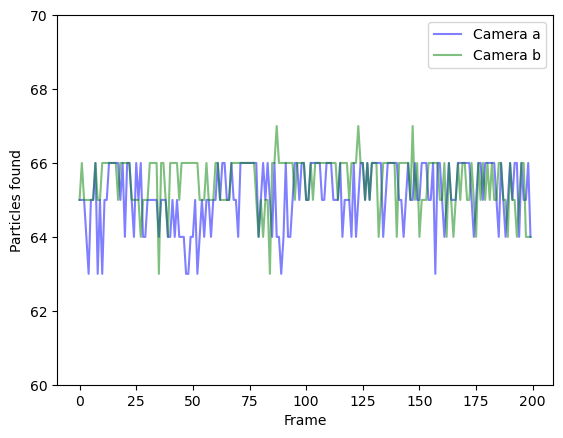

In [10]:
# Plot the number of particles found by camera a and b over time in one figure
fig, ax = plt.subplots()
ax.plot(range(200), particles_foundA, alpha=0.5, c="b",
label='Camera a')
ax.plot(range(200), particles_foundB, alpha=0.5, c="g", 
            label='Camera b')
ax.set_xlabel('Frame')
ax.set_ylabel('Particles found')
ax.set_ylim([60, 70])
ax.legend()
plt.show()

Converting the pixel values to meters and plotting all particle coordinates at 
once, gives us a good impression of the 
trajectories.

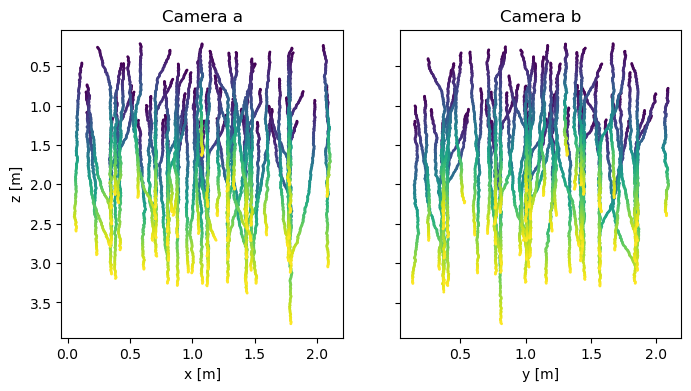

In [16]:
# Plot the particle coordinates of all frames in one image
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].scatter(coordsA[:, 1], coordsA[:, 0], c=coordsA[:,2], s=1)
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('z [m]')
ax[0].invert_yaxis()
ax[0].set_title('Camera a')
ax[1].scatter(coordsB[:, 1], coordsB[:, 0], c=coordsB[:,2], s=1)
ax[1].set_xlabel('y [m]')
ax[1].set_yticklabels([])
ax[1].invert_yaxis()
ax[1].set_title('Camera b')
plt.show()

### a3) 3D matching (6 points)
The 3D matching is done by taking the coordinates on the i-th image and 
taking the z-coordinate (vertical) of the particles on this image. We then 
find the closest matching z-coordinate on the other image. We do not yet 
track where the particle was on the previous frame, so our matching will not 
be perfect by any means. This is because the z-coordinate on the second frame
 which is closest to the first coordinate might not be the correct one and 
 this gives a very different y-coordinate than expected. This can only be 
 fixed by tracking where the particle was in the previous frame and making 
 sure the new coordinate is not too far from the previous coordinate. This is
  done in the next exercises. From now on, we use the resolution of camera a.
\
\
We also initially had the idea to first track our particles in 2D and then match the tracks on both cameras by their z-coordinate, however we believed this not to be the idea of the exercise, while we later learnt this would have been an acceptable approach. We believe a better plan would have been to make a good 2D tracker (which we did do) and then match the tracks found on camera A and B (which we did not have time for anymore).

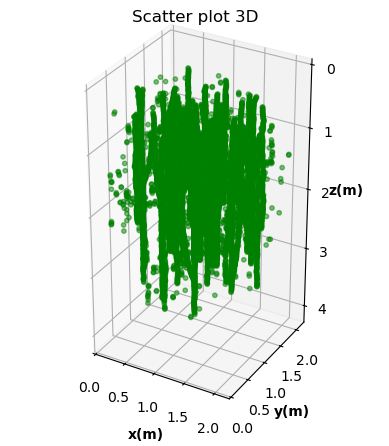

In [17]:
nN = 200
res = res_avg[0]
xA = np.zeros((len(coordsA), 2))
zA = np.zeros((len(coordsA), 2))
yB = np.zeros((len(coordsB), 2))
zB = np.zeros((len(coordsB), 2))

xA[:,0] = coordsA[:,1]
xA[:,1] = coordsA[:,2]
zA[:,0] = coordsA[:,0]
zA[:,1] = coordsA[:,2]

yB[:,0] = coordsB[:,1]
yB[:,1] = coordsB[:,2]
zB[:,0] = coordsB[:,0]
zB[:,1] = coordsB[:,2]

# matching particle tracks (without taking into account previous particle position)
x3D = np.zeros(0)
y3D = np.zeros(0)
z3DA = np.zeros(0)
z3DB = np.zeros(0)

for i in range(len(xA[:,0])):
    #take points on ith frame
    maskA = (xA[:,1] == i)
    maskB = (yB[:,1] == i)
    
    x = xA[:,0][maskA]
    y = yB[:,0][maskB]
    za = zA[:,0][maskA]
    zb = zB[:,0][maskB]
    
    for j in range(1, len(x)):
        #take z and x coordiate to match
        z0A = za[j]
        x0 = x[j]
        
        #find smallest distance between in list of zb and z0
        zlist = abs(zb - z0A)
        index = np.argmin(zlist) #finds index of smallest value, aka smallest distance
        
        
        
        y0 = y[index]
        z0B = zb[index]
        
        #save to arrays
        x3D = np.append(x3D, x0)
        y3D = np.append(y3D, y0)
        z3DA = np.append(z3DA, z0A)
        z3DB = np.append(z3DB, z0B)

# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
ax1.scatter(x3D, y3D, z3DA, color = "green", alpha = 0.5, s = 10)
#ax.scatter3D(x3D, y3D, z3DB, color = "blue", alpha = 0.5, s = 10)
plt.title("Scatter plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450*res)
ax1.set_ylim(0, 450*res)
ax1.set_zlim(860*(res_avg[0]), 0)
# show plot
plt.show()

### a4) Tracking (6 points)
We start our tracking at the start, then work our way forward and backwards, before connecting the found tracks. This does not use all points and tracks. The functions we wrote first uses nearest neighbour for the first few points, before switching to the predictor method using the velocity of the particle. We tried see if smoothing the already found tracks would help in using the predictor method, but this did not seem to be the case.
\
\
Three functions pass through the points (PTV_3D_Final, PTV_3D_Final_forw, PTV_3D_Final_back), the first starts at a point in the middle and works up and down, the second only goes forward and the last goes backwards. The tracks which come out of the function are checked with the "removal" function to see if there are any outliers or paths that should be split. "remove_duplicate_tracks" is then used to remove duplicate tracks if there are any, in the same pass. Then "remove_duplicates" is used to find the unique paths in each pass. "removal" is used again to fix particle numbering and then "remove_shorties" removes paths which are deemed too short.

In [20]:
from PTV_functions import PTV_3D_Final
from PTV_functions import PTV_3D_Final_forw
from PTV_functions import PTV_3D_Final_back
from PTV_functions import removal
from PTV_functions import remove_duplicate_tracks
from PTV_functions import remove_duplicates
from PTV_functions import remove_shorties

min_length = 10
#forward pass
x3d, y3d, z3d = PTV_3D_Final_forw(xA, zA, yB, zB, middle_frame=1, R=6*res,Rz=5*res, Rv=3*res, n_vel=4)
x, y, z = remove_duplicate_tracks(x3d, y3d, z3d) #remove duplicate tracks
x, y, z = removal(x, y, z, Rmax=0.05) #remove outliers and split paths
x, y, z = remove_shorties(x, y, z, n=min_length) # remove short paths
x3d, y3d, z3d = removal(x, y, z, Rmax=0.05) #fixes particle numbers if nessesary

#backward pass
x3d_new, y3d_new, z3d_new = PTV_3D_Final_back(xA, zA, yB, zB, middle_frame=1, R=6*res,Rz=5*res, Rv=3*res, n_vel=4)
x, y, z = remove_duplicates(x3d, y3d, z3d, x3d_new, y3d_new, z3d_new) #remove duplicates between known paths and new paths
x, y, z = remove_duplicate_tracks(x, y, z) #remove duplicate tracks
x, y, z = removal(x, y, z, Rmax=0.05) #fixes outliers and particle numbers
x, y, z = remove_shorties(x, y, z, n=min_length) # remove short paths
x3d_new, y3d_new, z3d_new = removal(x, y, z, Rmax=0.05) #fixes particle numbers if nessesary

maxp = np.max(x3d[:,2])#max_particles
x3d_new[:,2] = x3d_new[:,2] + maxp +1
y3d_new[:,2] = y3d_new[:,2] + maxp +1
z3d_new[:,2] = z3d_new[:,2] + maxp +1

#new array of particles
x3d = np.vstack((x3d, x3d_new))
y3d = np.vstack((y3d, y3d_new))
z3d = np.vstack((z3d, z3d_new))
        
#middle pass
x3d_new, y3d_new, z3d_new = PTV_3D_Final(xA, zA, yB, zB, middle_frame=76, R=6*res,Rz=5*res, Rv=3*res, n_vel=4)
x, y, z = remove_duplicates(x3d, y3d, z3d, x3d_new, y3d_new, z3d_new) #remove duplicates between known paths and new paths
x, y, z = remove_duplicate_tracks(x, y, z) #remove duplicate tracks
x, y, z = removal(x, y, z, Rmax=0.05) #fixes outliers and particle numbers
x, y, z = remove_shorties(x, y, z, n=min_length) # remove short paths
x3d_new, y3d_new, z3d_new = removal(x, y, z, Rmax=0.05) #fixes particle numbers if nessesary

maxp = np.max(x3d[:,2])#max_particles
x3d_new[:,2] = x3d_new[:,2] + maxp +1
y3d_new[:,2] = y3d_new[:,2] + maxp +1
z3d_new[:,2] = z3d_new[:,2] + maxp +1

#new array of particles
x3d = np.vstack((x3d, x3d_new))
y3d = np.vstack((y3d, y3d_new))
z3d = np.vstack((z3d, z3d_new))

#final paths
path_xA = x3d
path_yB = y3d
path_zA = z3d

100%|██████████| 65/65 [00:01<00:00, 58.86it/s]


remove duplicate tracks


100%|██████████| 12050/12050 [02:50<00:00, 70.80it/s]


removal
remove shorties
removal


100%|██████████| 64/64 [00:01<00:00, 56.78it/s]


remove duplicates (diff)


100%|██████████| 11280/11280 [02:32<00:00, 73.80it/s]


remove duplicate tracks


100%|██████████| 3515/3515 [00:14<00:00, 250.24it/s]


removal
remove shorties
removal


100%|██████████| 66/66 [00:00<00:00, 91.79it/s] 


remove duplicates (diff)


100%|██████████| 14199/14199 [02:58<00:00, 79.65it/s]


remove duplicate tracks


100%|██████████| 2278/2278 [00:06<00:00, 378.03it/s]

removal
remove shorties
removal


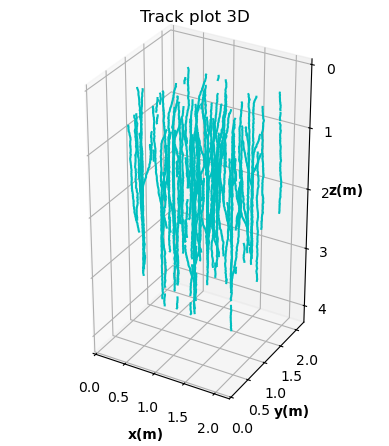

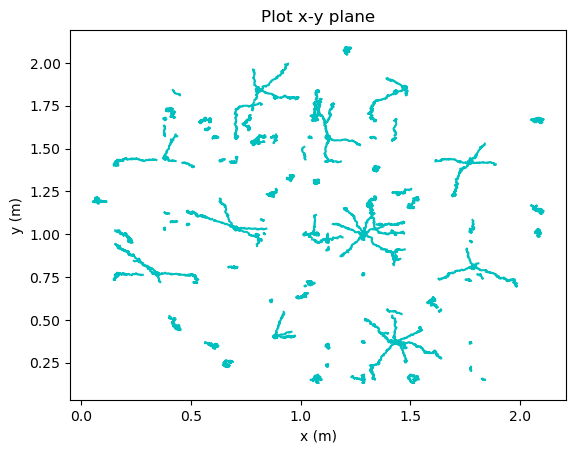

In [22]:
# Creating figure
fig = plt.figure()
ax1 = plt.axes(projection ="3d")
ax1.set_box_aspect((450, 450, 860))
# Creating plot
for i in range(0, int(np.max(y3d[:,2]))+1):
    mask = (y3d[:,2]==i)
    ax1.plot(x3d[:,0][mask], y3d[:,0][mask], z3d[:,0][mask],c='c')
plt.title("Track plot 3D")
ax1.set_xlabel('x(m)', fontweight ='bold') 
ax1.set_ylabel('y(m)', fontweight ='bold') 
ax1.set_zlabel('z(m)', fontweight ='bold')
ax1.set_xlim(0, 450*(res_avg[0]))
ax1.set_ylim(0, 450*(res_avg[0]))
ax1.set_zlim(860*(res_avg[0]), 0)
# show plot

plt.figure()
plt.title('Plot x-y plane')
for i in range(0, int(np.max(y3d[:,2]))+1):
    mask = (y3d[:,2]==i)
    plt.plot(x3d[:,0][mask], y3d[:,0][mask], c='c')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


#### Our attempt at 2D matching and then matching the tracks, we did not get further than making a 2D tracker, we did not have time to match tracks to make them 3D ####

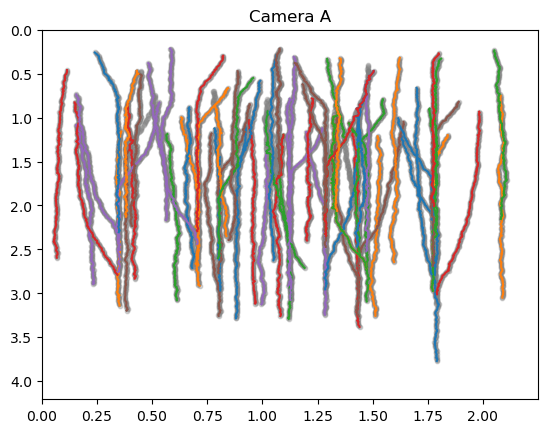

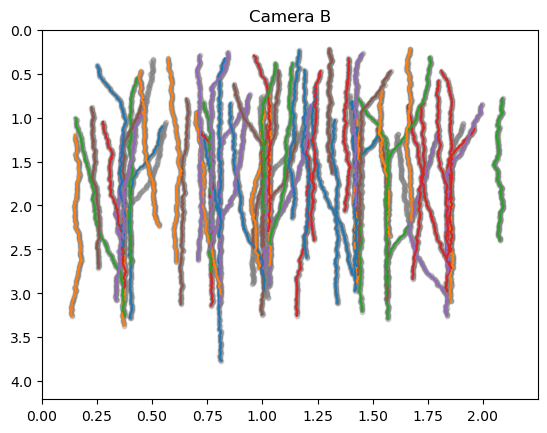

In [23]:
from PTV_functions import PTV_2DMiddle

#find 2D paths
xA_m, zA_m = PTV_2DMiddle(xA, zA, middle_frame=65, n_velocity=2, Rmax_v=5*res, Rmax_n=3*res, nN=200)
yB_m, zB_m = PTV_2DMiddle(yB, zB, middle_frame= 136, n_velocity=4, Rmax_v=6*res, Rmax_n=3*res, nN=200)
# Plot data
plt.figure()
plt.scatter(xA[:, 0], zA[:,0], alpha=0.3, c='gray', s=10)
for i in range(0, int(np.max(xA_m[:,2]))+1):
    mask = (xA_m[:,2]==i)
    plt.plot(xA_m[:,0][mask], zA_m[:,0][mask], c = f'C{i%6}')
plt.ylim(860*res, 0)
plt.xlim(0, 460*res)
plt.title('Camera A')
plt.show()

# Plot data
plt.figure()
plt.scatter(yB[:, 0], zB[:,0], alpha=0.3, c='gray', s=10)
for i in range(0, int(np.max(yB_m[:,2]))+1):
    mask = (yB_m[:,2]==i)
    plt.plot(yB_m[:,0][mask], zB_m[:,0][mask], c = f'C{i%6}')
plt.ylim(860*res, 0)
plt.xlim(0, 460*res)
plt.title('Camera B')
plt.show()

### a5) Velocity

To calculate the velocities of the particles, we take the track of a particle (which is sorted by time) and calculate the velocities in the horizontal and vertical directions. In the PDFs below we can see that the velocity is the x- and y-directions have approximately the same probability density function, while the velocity in the z-direction is generally higher and positive (which means downwards in this case). The PDFs also seem to be Gaussian in shape. However, the paths we have found are quite jagged, so it may be beneficial to smooth our paths. We do this below too, we visually inspected the smoothed paths to make sure that the new paths are not over smoothed. We see that the PDFs remain pretty much the same as before.

In [24]:
fps = 25 #Hz
dt = 1/fps
p = 1 #between particles
vx = np.zeros(0)
vy = np.zeros(0)
vz = np.zeros(0)
for i in tqdm(range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    #find track of ith particle
    mask = (path_xA[:,2]==i)
    x = path_xA[:,0:2][mask]
    y = path_yB[:,0:2][mask]
    z = path_zA[:,0:2][mask]
    
    #calculate velocities
    for j in range(len(x)-p): #for each frame
        distance_x = (x[j+1,0]-x[j, 0])
        distance_y = (y[j+1,0]-y[j, 0])
        distance_z = (z[j+1,0]-z[j, 0])
        time = dt*(x[j+1,1]-x[j,1])
        
        vx = np.append(vx, distance_x/time)
        vy = np.append(vy, distance_y/time)
        vz = np.append(vz, distance_z/time)

100%|██████████| 247/247 [00:00<00:00, 1181.81it/s]


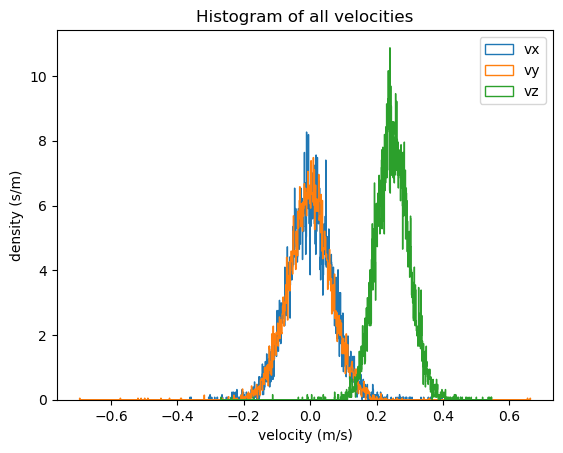

In [25]:
plt.figure()
plt.hist(vx, bins=1000, density=True, histtype='step', label='vx')
plt.hist(vy, bins=1000, density=True, histtype='step', label='vy')
plt.hist(vz, bins=1000, density=True, histtype='step', label='vz')
plt.title('Histogram of all velocities')
plt.xlabel('velocity (m/s)')
plt.ylabel('density (s/m)')
plt.legend()
plt.show()

100%|██████████| 247/247 [00:00<00:00, 895.31it/s] 


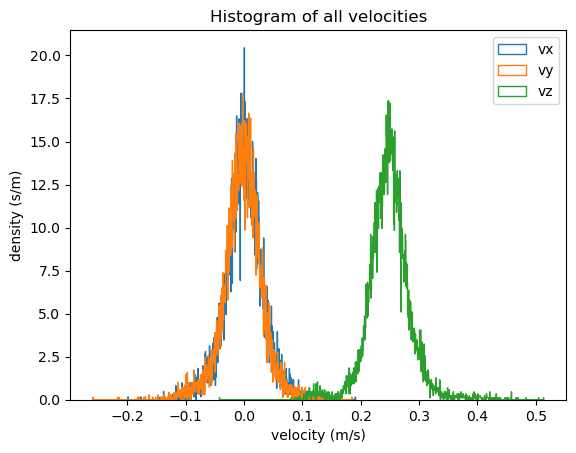

In [26]:
fps = 25 #Hz
dt = 1/fps
p = 1 #between particles
vx = np.zeros(0)
vy = np.zeros(0)
vz = np.zeros(0)

from scipy import signal

for i in tqdm(range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    #find track of ith particle
    mask = (path_xA[:,2]==i)
    x = path_xA[:,0:2][mask]
    y = path_yB[:,0:2][mask]
    z = path_zA[:,0:2][mask]
    if len(x)>=10:
        xs = signal.savgol_filter(x[:,0], 10, 3)
        ys = signal.savgol_filter(y[:,0], 10, 3)
        zs = signal.savgol_filter(z[:,0], 10, 3)

        #calculate velocities
        for j in range(len(x)-p): #for each frame
            distance_x = (xs[j+1]-xs[j])
            distance_y = (ys[j+1]-ys[j])
            distance_z = (zs[j+1]-zs[j])
            time = dt*(x[j+1,1]-x[j,1])

            vx = np.append(vx, distance_x/time)
            vy = np.append(vy, distance_y/time)
            vz = np.append(vz, distance_z/time)
        
plt.figure()
plt.hist(vx, bins=1000, density=True, histtype='step', label='vx')
plt.hist(vy, bins=1000, density=True, histtype='step', label='vy')
plt.hist(vz, bins=1000, density=True, histtype='step', label='vz')
plt.title('Histogram of all velocities')
plt.xlabel('velocity (m/s)')
plt.ylabel('density (s/m)')
plt.legend()
plt.show()

### a6) Alignment (3 points)
To find the alignments we first find the particles which are within 0.4 meters of another particle, we then calculate the angle between the two particles using the equation $\theta=\arccos{\frac{\sqrt{(x_i - x_{i+1})^2 + (y_i - y_{i+1})^2}}{(z_i - z_{i+1})}}$. Making use of the the following coordinate system:

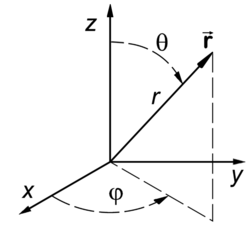

In [28]:
from IPython.display import Image
 
Image(filename='coordinates.png', width=400)

We see in the histogram below, that for the first 100 frames there seem to be
 three angles which are slightly prefered over others, the middle one being 
 at $\pi/2$ and with two peaks on either side. The last 100 frames shows that
  there is a clear preference for the particles to be at an angle around $\pi/2$. We suspect that the dip at $\pi/2$ comes from the fact that there might be particles next to another horizontally and one particle then dissappears behind the other and it is no longer detected.

In [29]:
angle_1to99 = np.zeros(0)
angle_100to200 = np.zeros(0)

import math

for i in (range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    for j in range(1, 100+1): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 0.4) #should be 0.4 meter, but didn't include calibration yet
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
                angle_1to99 = np.append(angle_1to99, theta)
    
                   
for i in (range(0, int(np.max(path_xA[:,2])+1))): #for each particle
    for j in range(100, 201): #for each frame
        mask = (path_xA[:,2] == i) & (path_xA[:,1] == j) #for particle i, on frame j
        x = path_xA[:,0][mask]
        y = path_yB[:,0][mask]
        z = path_zA[:,0][mask]
        
        if len(x) != 0:
        
            mask2 = (path_xA[:,2] != i) & (path_xA[:,1] == j) #for all other particles, on frame j
            x_other = path_xA[:,0][mask2]
            y_other = path_yB[:,0][mask2]
            z_other = path_zA[:,0][mask2]

            distances = np.sqrt(abs(x-x_other)**2 + abs(y-y_other)**2 + abs(z-z_other)**2)
            mask3 = (distances <= 0.4) #should be 0.4 meter
            x_other = x_other[mask3]
            y_other = y_other[mask3]
            z_other = z_other[mask3]
            
            #print(x_other)

            #calculate angle somehow
            for k in range(len(x_other)):
                theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
                angle_100to200 = np.append(angle_100to200, theta)
    
                   
        

/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_60143/3541546952.py:30: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_60143/3541546952.py:30: RuntimeWarning: divide by zero encountered in divide
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_60143/3541546952.py:58: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))
/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_60143/3541546952.py:58: RuntimeWarning: divide by zero encountered in divide
  theta = np.arccos(np.sqrt(abs(x-x_other[k])**2 + abs(y-y_other[k])**2)/(z-z_other[k]))


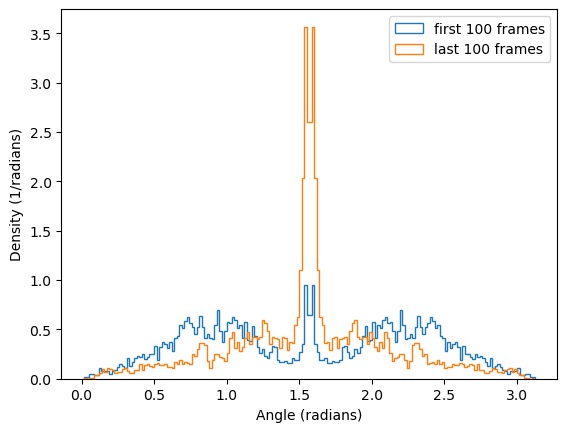

In [30]:
plt.figure()
plt.hist(angle_1to99, bins=180, density='True', histtype='step', label='first 100 frames')
plt.hist(angle_100to200, bins=180, density='True', histtype='step', label='last 100 frames')
plt.xlabel('Angle (radians)')
plt.ylabel('Density (1/radians)')
plt.legend()
plt.show()

## Appendix

### functions1.py

In [ ]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm import tqdm
from natsort import natsorted


def read_image(file_path, roi=None, grayscale=True):
    """
    Read an image from a file and crop it to a region of interest (ROI).

    PARAMETERS:
        file_path (str): The path to the image file.
        roi (list): A list of four integers [x0, x1, z0, z1], specifying the
            region of interest (default: None).
        grayscale (bool): Whether to read the image in grayscale
            (default: True).

    RETURNS:
        array: The cropped image.
    """

    # If grayscale is specified, read the image in grayscale
    if grayscale:
        image = cv.imread(file_path, 0)

    # If not, read the image in color
    else:
        image = cv.imread(file_path)

    # Crop the image to the region of interest
    if roi is not None:
        image = image[roi[2]:roi[3], roi[0]:roi[1]]

    return image


def read_image_series(directory, prefix=None, roi=None, grayscale=True,
                      timeit=True):
    """
    Read a series of images from a directory and crop them to a region of
    interest (ROI).

    PARAMETERS:
        directory (str): The path to the directory containing the images.
        prefix (str): A common prefix for the image files (default: None).
        roi (list): A list of four integers [x0, x1, z0, z1], specifying the
            region of interest (default: None).
        grayscale (bool): Whether to read the images in grayscale
            (default: True).
        timeit (bool): Whether to print the time taken to read the images
            (default: False).

    RETURNS:
        tuple: A tuple containing a list of images and a list of file names.
    """

    # Get a list of all files in the directory
    files = os.listdir(directory)

    # If a prefix is specified, filter the list of files
    if prefix is not None:
        files = [f for f in files if f.startswith(prefix)]

    # Sort the list of files
    files = natsorted(files)

    # Read the images and store them in a list
    images = [read_image(os.path.join(directory, f), roi, grayscale=grayscale)
              for f in tqdm(files, disable=not timeit, desc="Reading images")]

    return images, files


def all_distances(x, y=None):
    """Calculate the distance between all points in a 2D (x,y) space

    PARAMETERS:
        x (np.array): The x-coordinates of the points
        y (np.array): The y-coordinates of the points

    RETURNS:
        distances_px (np.array): The distances between all points
    """

    # If only one array is given, assume the other one contains only zeros
    if y is None:
        y = np.zeros_like(x)

    # Combine the x and y coordinates into a single array
    xy = np.column_stack([x, y])

    # Calculate the distance between all points
    distances = spatial.distance.cdist(xy, xy, 'euclidean')

    return distances


def weighted_avg_and_std(values, weights, mask_diagonal=True,
                         verbose=False, precision=6, units="mm"):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted
            average and standard deviation.
        weights (array-like): The weights corresponding to each value.
        mask_diagonal (bool): Whether to mask the diagonal of the
            distance matrix (default: True).
        verbose (bool): Whether to print the results (default: False).
        precision (int): In the verbose output, the number of decimal places to
            round the results to (default: 5).
        units (str): In the verbose output, the length units of the values
            (default: "mm").

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal:
        mask = np.eye(values.shape[0], dtype=bool).__invert__()
    else:
        mask = np.ones_like(values, dtype=bool)

    # Calculate the weighted average
    average = np.average(values[mask], weights=weights[mask])

    # Calculate the weighted variance and standard deviation
    variance = np.average((values[mask] - average) ** 2, weights=weights[mask])
    deviation = np.sqrt(variance)

    if verbose:
        print(f"The average resolution is {average:.{precision}f} {units}/px,")
        print(f"with a standard deviation of {np.sqrt(variance):.{precision}f}"
              f" {units}/px ({100 * deviation / average:.2} %).")

    # Output the average and standard deviation
    return average, deviation


def intensity_peaks(profile, method='weighted_avg', threshold=85):
    """
    Find the peaks in an intensity profile.

    PARAMETERS:
        profile (array-like): The intensity profile.
        method (str): The method to use for peak detection
            (default: 'weighted_avg').
        threshold (float): The threshold for peak detection (default: 85).

    RETURNS:
        array: The indices of the peaks in the profile.
    """

    # METHOD #1: WEIGHTED INTENSITY AVERAGE
    if method == 'weighted_avg':

        # For each z coordinate...
        peak_indices = []
        peak_intensities = []
        current_group = []
        for idx in range(len(profile)):

            # Check whether the current row is above the threshold
            if profile[idx] > threshold:

                # If so, append the row number to the list of peak indices
                current_group.append(idx)
            else:

                # If not, check whether this is the end of a peak
                if len(current_group) > 0:
                    # Calculate the average intensity
                    peak_intensities.append(np.mean(profile[current_group]))

                    # Calculate an average peak coordinate, weighted by the
                    # intensity
                    peak_indices.append(
                            np.dot(profile[current_group], current_group) /
                            np.sum(profile[current_group]))

                    # Reset the current peak group
                    current_group = []

    # METHOD 2: GAUSSIAN FITTING
    elif method == 'gaussian_fit':
        raise NotImplementedError("Gaussian fitting has not been implemented.")

    # Throw error if wrong method is specified
    else:
        raise ValueError(f"Unknown method '{method}'")

    # Return the (subpixel precision) indices of the peaks and their intensities
    return peak_indices, peak_intensities


def calibrate_camera(image, calib_dist, threshold, peak_method='weighted_avg',
                     plot=False, file_name=None, verbose=False, units="mm",
                     precision=3):
    """
    Calibrate the resolution of a camera using a calibration image.

    PARAMETERS:
        image (array-like): The calibration image.
        calib_dist (float): The known distance between the peaks in the image.
        threshold (float): The threshold for peak detection.
        peak_method (str): The method to use for peak detection
        plot (bool): Whether to plot the results (default: False).
        file_name (str): When plotting, the name of the file to use as
            the figure title
        verbose (bool): Whether to print the results (default: False).
        precision (int): In the verbose output, the number of decimal places to
            round the results to (default: 5).
        units (str): In the verbose output, the length units of the values
            (default: "mm").

    RETURNS:
        tuple: A tuple containing the average resolution, standard deviation,
            and the line heights.
    """

    # Average all pixels in the x-direction to get the intensity profile
    int_profile = np.mean(image, axis=1)

    # Calculate the peaks in the intensity profile
    line_height, peak_intensities\
        = intensity_peaks(int_profile, method=peak_method, threshold=threshold)
    # Idea: the peak intensities could be used as a measure of error

    # Calculate the distances between all peaks
    dist_px = all_distances(line_height)

    # Define an array of distances in real units and calculate all distances
    peak_re = calib_dist * np.arange(0, len(line_height))
    dist_re = all_distances(peak_re)

    # Ignoring division by zero...
    with np.errstate(divide='ignore', invalid='ignore'):
        # ...calculate the resolutions of the image in units length per pixel
        res_matrix = dist_re / dist_px

    # Calculate the weighted average and standard deviation of the resolutions
    res_avg, res_std = weighted_avg_and_std(res_matrix, dist_px,
                                            verbose=verbose, units=units,
                                            precision=precision)

    # Plot the cropped image and intensity profile side-by-side
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(6, 9))

        # Use file name to generate figure title
        if file_name is not None:
            fig.suptitle(file_name)

        # Plot the cropped image
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Calibration (cropped)')
        ax[0].set_xlabel('x [px]')
        ax[0].set_ylabel('z [px]')

        # Plot the intensity profile
        ax[1].plot(int_profile, np.arange(0, len(int_profile)), '.')
        ax[1].set_title('Intensity profile')
        ax[1].set_xlabel('|I| (a.u.)')

        # Plot the intensity peaks
        ax[1].plot(peak_intensities, line_height, 'rx')

        # Add a vertical line for the threshold
        ax[1].axvline(threshold, color='r', linestyle='--')

        # Flip and scale the profile axis to match the image
        ax[1].invert_yaxis()
        ax[1].set_ylim([len(int_profile), 0])

        # Add an extra vertical axis on the right containing the values in mm
        ax2 = ax[1].twinx()
        ax2.set_ylabel('z [m]')
        ax2.invert_yaxis()
        ax2.set_ylim([len(int_profile) * res_avg / 1000, 0])

        # Add legend
        ax[1].legend(['Mean intensity', 'Avg. peaks', 'Threshold'],
                     loc='upper left')
        plt.show()

    return res_avg, res_std, line_height


def calibrate_cameras(directory, roi, calib_dist, threshold,
                      peak_method='weighted_avg',
                      file_prefix='Calibration',
                      plot=False, verbose=True, units="m", precision=7):
    """
    Calibrate the resolution of a series of cameras using calibration images.

    PARAMETERS:
        directory (str): The path to the directory containing the calibration
            images.
        roi (list): A list of four integers [x0, x1, z0, z1], specifying the
            region of interest.
        calib_dist (float): The known distance between the peaks in the image.
        threshold (float): The threshold for peak detection.
        peak_method (str): The method to use for peak detection
            (default: 'weighted_avg').
        file_prefix (str): A common prefix for the image files
            (default: 'Calibration').
        plot (list(bool)): Which camera's results to plot (default: False).
        verbose (bool): Whether to print the results (default: True).
        units (str): In the verbose output, the length units of the values
            (default: "m").
        precision (int): In the verbose output, the number of decimal places to
            round the results to (default: 7).
    """

    # Read the calibration images in grayscale [z, x]
    calib_images, files = read_image_series(directory, prefix=file_prefix,
                                            roi=roi, timeit=False)
    no_images = len(calib_images)

    # Generate an array of plot flags
    if plot is True:
        plot = np.ones(no_images, dtype=bool)
    elif plot is False:
        plot = np.zeros(no_images, dtype=bool)
    elif isinstance(plot, (list, tuple, np.ndarray)):
        plot = np.array(plot, dtype=bool)
    else:
        raise ValueError("Invalid value for 'plot'")

    # Pre-allocate
    res_avg, res_std, offset = (np.zeros(no_images), np.zeros(no_images),
                                np.zeros(no_images))

    # For each calibration image...
    for idx, calib_image in enumerate(calib_images):
        # Print the camera name
        if verbose:
            print(f"==> {files[idx]}:")

        # Get the average resolution and standard deviation
        res_avg[idx], res_std[idx], line_height_idx \
            = calibrate_camera(calib_image, calib_dist, threshold,
                               peak_method=peak_method,
                               plot=bool(plot[idx]), file_name=files[idx],
                               verbose=verbose, units=units,
                               precision=precision)

        # Store the line heights of the first camera
        if idx == 0:
            line_height_0 = line_height_idx
            offset[0] = 0

        # If this is not the first camera, compare the line locations
        else:
            line_diff = np.array(line_height_idx) - np.array(line_height_0)

            # The offset is given by the mean of the differences
            offset[idx] = res_avg[idx] * np.mean(line_diff)

            # Print the offset
            if verbose:
                print(f"The offfset is {offset[idx]:.{precision}f} {units}.")

    return res_avg, res_std, offset

### functions2.py

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
from tqdm import tqdm

from . import all_distances, read_image_series


def remove_hits(img, mode):
    """ Remove specific patterns from an image using a hit-or-miss transform.

    ARGUMENTS:
        img (np.array): The image to be processed.
        mode (str): The mode of the hit-or-miss transform to be applied.

    RETURNS:
        img (np.array): The processed image.
    """

    # Define different kernels
    if mode == 'single':
        kernel = np.array([[0, -1, 0],
                           [-1, +1, -1],
                           [0, -1, 0]])
    elif mode == 'horizontal':
        kernel = np.array([[-1, -1, -1],
                           [0, +1, 0],
                           [-1, -1, -1]])
    elif mode == 'vertical':
        kernel = np.array([[-1, 0, -1],
                           [-1, +1, -1],
                           [-1, 0, -1]])
    else:
        raise ValueError('Mode not recognized')

    # Binarize the image
    img_binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY)[1]

    # Perform a hit-or-miss transform on a binary version
    #   to remove matching pixels
    img_singles = cv.morphologyEx(img_binary, cv.MORPH_HITMISS, kernel)

    # Edit the original image
    img[img_singles == 255] = 0

    return img


def remove_background(img, contours=None, sigma_color1=50, sigma_space1=9,
                      sigma_color2=20, sigma_space2=3, noise_threshold=50):
    """
    Remove background from an image using a bilateral filter and
    a hit-or-miss transform.

    ARGUMENTS:
        img (np.array): The image to be processed.
        contours (list): The contours of the particles in the image
            (default: None).
        sigma_color1 (int): The color sigma of the first bilateral filter
            (default: 50).
        sigma_space1 (int): The space sigma of the first bilateral filter
            (default: 9).
        sigma_color2 (int): The color sigma of the second bilateral filter
            (default: 20).
        sigma_space2 (int): The space sigma of the second bilateral filter
            (default: 3).
        noise_threshold (int): The threshold for the to-zero threshold
            (default: 50).

    RETURNS:
        img_proc (np.array): The processed image.
    """

    # MODE 1: If contours are not given, clean up the image
    if contours is None:

        # Apply a bilateral filter to remove noise while keeping edges sharp
        img_proc = cv.bilateralFilter(img, d=-1, sigmaColor=sigma_color1,
                                      sigmaSpace=sigma_space1)

        # Apply another bilateral filter for finer detail removal
        img_proc = cv.bilateralFilter(img_proc, d=-1, sigmaColor=sigma_color2,
                                      sigmaSpace=sigma_space2)

        # Set all pixels below a certain threshold to zero with a
        #   to-zero threshold
        _, img_proc = cv.threshold(img_proc, noise_threshold, 255,
                                   cv.THRESH_TOZERO)

        # Remove a bunch of specific patterns
        img_proc = remove_hits(img_proc, 'horizontal')
        img_proc = remove_hits(img_proc, 'vertical')
        # img_proc = remove_hits(img_proc, 'single') # This one is not necessary

    # MODE 2: If contours are provided, remove all pixels but the contours
    else:
        # Create a mask of the contours and their interiors
        mask = np.zeros_like(img)
        mask = cv.drawContours(mask, contours, -1, 255, -1)

        # Set the pixels outside the contours to zero
        img_proc = np.where(mask == 255, img, 0)

    return img_proc


def remove_contours(img, contours, keep_index=None):
    """
    Remove specific contours from an image.

    ARGUMENTS:
        img (np.array): The image to be processed.
        contours (list): The contours to be removed.
        keep_index (int): The index of the contour to be kept (default: None).

    RETURNS:
        img_proc (np.array): The processed image.
    """

    # If a specific contour is to be kept, remove it from the list
    if keep_index is not None:
        contours = [contour for i, contour in enumerate(contours)
                    if i != keep_index]

    # Set the pixels on the contours to zero
    img_proc = img.copy()
    img_proc = cv.drawContours(img_proc, contours, -1, 0, -1)

    return img_proc


def remove_sublists(list_of_lists):
    """
    Remove sublists and duplicates from a list of lists.
    Source: https://geeksforgeeks.org/python-remove-sublists-that-are-present-in-another-sublist/

    ARGUMENTS:
        list_of_lists: list of lists (might be inhomogeneous)

    RETURNS:
        results: list of lists with sublists removed
    """

    # Pre-allocation
    current_sublist = []
    results = []

    # Convert each element to a set and sort by descending length
    for element in sorted(map(set, list_of_lists), key=len, reverse=True):

        # Add only sets that are not already part of current_sublist
        if not any(element <= number for number in current_sublist):
            current_sublist.append(element)
            results.append(list(element))

    return results


def split_clusters(peak_indices, neighbor_dist=1.5):
    """
    Split a set of maxima into clusters based on their Euclidean distance.

    ARGUMENTS:
        peak_indices (np.array): The indices of the maxima
            [coordinate, peak index].
        neighbor_dist (float): The maximum distance between maxima to be
            considered part of the same cluster (default: 1.5).

    RETURNS:
        peak_clusters (list): A list of lists, where each sublist contains
            the indices of the peaks that belong together in a cluster.
    """

    # Check the Euclidian distances between the maxima
    dists = all_distances(peak_indices[0, :], peak_indices[1, :])

    # Get the indices of all the groups that are within a certain distance
    peak_clusters = [[i for i, val in enumerate(dists[:, col])
                      if val < neighbor_dist] for col in range(dists.shape[1])]

    # Remove subsets and duplicates
    peak_clusters = remove_sublists(peak_clusters)

    return peak_clusters


def get_neighbors(peak_indices, peak_indices_new, peak_intensities_new,
                  neighbor_dist=1.5):
    """
    Get the points in a new set of maxima that are neighbors of the points in
    the original set.

    ARGUMENTS:
        peak_indices (np.array): The indices of the original maxima.
        peak_indices_new (np.array): The indices of the new maxima.
        peak_intensities_new (np.array): The intensities of the new maxima.
        neighbor_dist (float): The maximum distance between maxima to be
            considered neighbors (default: 1.5).

    RETURNS:
        peak_indices_new (np.array): The indices of the new maxima that are
            neighbors of the original maxima.
        peak_intensities_new (np.array): The intensities of the new maxima that
            are neighbors of the original maxima.
    """

    # Initialize an empty list to store the indices of peak_indices_new
    #   that are within 1 pixel distance
    indices_within_1_pixel = []

    # Iterate over each point in peak_indices_new
    for i, point_new in enumerate(peak_indices_new.T):
        # Calculate the Euclidean distance to all points in peak_indices
        distances = np.sqrt(
                np.sum((peak_indices - point_new.reshape(-1, 1)) ** 2, axis=0))

        # If the minimum distance is less than or equal to a given distance,
        # append the index to indices_within_1_pixel
        if np.min(distances) <= neighbor_dist:
            indices_within_1_pixel.append(i)

    # Select the points from peak_indices_new that are within 1 pixel distance
    peak_indices_new = peak_indices_new[:, indices_within_1_pixel]

    # Also get the corresponding intensities
    peak_intensities_new = peak_intensities_new[indices_within_1_pixel]

    return peak_indices_new, peak_intensities_new


def destroy_neighbors(box_indices, box_intensities, peak_indices,
                      peak_intensities, max_iter=3, neighbor_dist=1.5):
    """
    Iteratively remove maxima in a cluster until only one maximum remains.

    ARGUMENTS:
        box_indices (np.array): The indices of the region.
        box_intensities (np.array): The intensities of the region.
        peak_indices (np.array): The indices of the maxima.
        peak_intensities (np.array): The intensities of the maxima.
        max_iter (int): The maximum number of iterations to remove neighbouring
            maxima (default: 3).
        neighbor_dist (float): The maximum distance between maxima to be
            considered part of the same cluster (default: 1.5).

    RETURNS:
        peak_indices (np.array): The indices of the final maxima.
        peak_intensities (np.array): The intensities of the final maxima.
    """

    # Keep track of the number of iterations
    iteration = 0

    # If there are (still) neighbors in the set of maxima...
    while peak_indices.shape[1] > 1:

        # Perform a small Gaussian blur on the region
        box_intensities = cv.GaussianBlur(box_intensities, (3, 3), 0,
                                          borderType=cv.BORDER_CONSTANT)

        # Get the new local maxima
        peak_indices_new, peak_intensities_new \
            = find_local_max(box_indices, box_intensities, min_intensity=0)

        # Delete any maxima that are not direct (diagonal)
        #   neighbours from the original set
        peak_indices_new, peak_intensities_new \
            = get_neighbors(peak_indices, peak_indices_new,
                            peak_intensities_new,
                            neighbor_dist=neighbor_dist)

        # If all neighbours were removed, signifying a very small island...
        if peak_indices_new.shape[1] == 0:

            # Pick the first maximum and break the loop
            peak_indices = peak_indices[:, [0]]
            peak_intensities = peak_intensities[[0]]
            break

        # Else, update the maxima
        else:
            peak_indices = peak_indices_new
            peak_intensities = peak_intensities_new

        # Go to the next iteration
        iteration += 1

        # If the max number of iterations is reached...
        if iteration >= max_iter:
            # Pick the first maximum and break the loop
            peak_indices = peak_indices[:, [0]]
            peak_intensities = peak_intensities[[0]]
            break

    return peak_indices, peak_intensities


def find_local_max(all_indices, all_intensities, min_intensity=100):
    """
    Find the local maxima in a region of interest.

    ARGUMENTS:
        all_indices (np.array): The indices of the region.
        all_intensities (np.array): The intensities of the region.
        min_intensity (int): The minimum intensity of a local maximum
            (default: 100).

    RETURNS:
        peak_indices (np.array): The indices of the maxima.
        peak_intensities (np.array): The intensities of the maxima.
    """

    # Apply a maximum filter on this (processed) region
    peak_intensities = ndimage.maximum_filter(all_intensities, size=3)

    # Filter out maxima of 0 at the edges (these are not real maxima)
    peak_intensities = np.where(peak_intensities == 0, -1, peak_intensities)

    # Filter out maxima with a low intensity
    peak_intensities = np.where(peak_intensities < min_intensity, -1,
                                peak_intensities)

    # Get the indices corresponding to the peaks
    peak_indices = all_indices[:, all_intensities == peak_intensities]

    # Get the intensities of the peaks
    peak_intensities = all_intensities[all_intensities == peak_intensities]

    # If no maxima were detected
    if peak_indices.shape[1] == 0:
        # Return nothing
        return None, None

    return peak_indices, peak_intensities


# noinspection PyTupleAssignmentBalance
def fit_gaussian_2d(box_indices, box_intensities, peak_index,
                    peak_sigma=None, plot=False):
    """
    Fit a Gaussian in two directions to the intensities around a local maximum.

    ARGUMENTS:
        box_indices (np.array): The indices of the region.
        box_intensities (np.array): The intensities of the region.
        peak_index (np.array): The index of the peak.
        peak_sigma (list): The spread of the peak in both directions
            (default: None).
        plot (bool): Whether to plot the box intensities with the fitted
            Gaussian.

    RETURNS:
        peak_fitted_index (np.array): The subpixel coordinates of the maxima.
        peak_fitted_intensity (np.array): The fitted intensities of the maxima.
        peak_fitted_index_std (np.array): The errors in the subpixel coordinates
            of the maxima.
        peak_fitted_intensity_std (np.array): The errors in the fitted
            intensities of the maxima.
    """

    # If no spread is specified, set it to 1 in both directions
    if peak_sigma is None:
        peak_sigma = [1, 1]

    # Define a Gaussian function to be used for fitting
    def gaussian(x, a, x0, sigma):
        return a * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

    # Define a set of slices around the peak in 2 directions
    x_indices = box_indices[1, peak_index[0], :].flatten()
    z_indices = box_indices[0, :, peak_index[1]].flatten()

    # Get the corresponding intensities
    x_intensities = box_intensities[peak_index[0], :].flatten()
    z_intensities = box_intensities[:, peak_index[1]].flatten()

    # Get the local maximum intensity
    peak_height = box_intensities[peak_index[0], peak_index[1]]

    # Use a try-except structure to catch failed fits
    try:
        # Fit the Gaussian in both directions
        x_parameters, x_covariance \
            = curve_fit(gaussian, x_indices, x_intensities,
                        p0=[peak_height, peak_index[1], peak_sigma[0]])
        z_parameters, z_covariance \
            = curve_fit(gaussian, z_indices, z_intensities,
                        p0=[peak_height, peak_index[0], peak_sigma[1]])

    # If it cannot be fitted, return nothing
    except RuntimeError:
        return None, None, None, None

    # Get the standard errors from the (diagonals of the) covariance matrices
    x_errors = np.sqrt(np.diag(x_covariance))
    z_errors = np.sqrt(np.diag(z_covariance))

    # Get the optimized peak indices (to be converted back to coordinates)
    peak_fitted_index = np.array([z_parameters[1], x_parameters[1]])
    peak_fitted_intensity = np.array([z_parameters[0], x_parameters[0]])

    # Get the errors
    peak_fitted_index_std = np.array([z_errors[1], x_errors[1]])
    peak_fitted_intensity_std = np.array([z_errors[0], x_errors[0]])

    # # Plot the box intensities with the fitted Gaussian
    if plot:
        # Define more detailed indices for the plot
        x_indices_fit = np.linspace(np.min(x_indices), np.max(x_indices), 100)
        z_indices_fit = np.linspace(np.min(z_indices), np.max(z_indices), 100)

        # Plot the box intensities with the fitted Gaussian
        fig, ax = plt.subplots()
        ax.plot(x_indices, x_intensities, 'b+', label='x data')
        ax.plot(z_indices, z_intensities, 'r+', label='z data')
        ax.plot(x_indices_fit, gaussian(x_indices_fit, *x_parameters),
                'b-', label='x fit')
        ax.plot(z_indices_fit, gaussian(z_indices_fit, *z_parameters),
                'r-', label='z fit')
        ax.legend()

    return (peak_fitted_index, peak_fitted_intensity,
            peak_fitted_index_std, peak_fitted_intensity_std)


def find_particle_center(img, contours, contour_no, min_intensity=100,
                         neighbor_dist=2, box_margin=2, max_iter=3,
                         plot_mult=False, plot_all=False):
    """
    Find the center of a particle at a contour in an image using
    subpixel fitting.

    ARGUMENTS:
        img (np.array): The image to be processed.
        contours (list): The contours in the image.
        contour_no (int): The index of the contour to be processed.
        min_intensity (int): The minimum intensity of a local maximum
            (default: 100).
        neighbor_dist (float): The maximum distance between maxima to be
            considered part of the same cluster (default: 2).
        box_margin (int): The margin to be added to the bounding box of the
            contour (default: 2).
        max_iter (int): The maximum number of iterations to remove neighbouring
            maxima (default: 3).
        plot_mult (bool): Whether to plot the isolated contour box if multiple
            clusters are found (default: False).
        plot_all (bool): Whether to plot all maxima found originally
            (default: False).

    RETURNS:
        peak_coord_fit (np.array): The subpixel coordinates of the maxima.
        peak_intensity_fit (np.array): The fitted intensities of the maxima.
        peak_coord_err (np.array): The errors in the subpixel coordinates of the
            maxima.
        peak_intensity_err (np.array): The errors in the fitted intensities of
            the maxima.
    """

    # === PART 1: GETTING THE BOUNDING BOX ===
    # Get the contour and calculate its bounding box
    cnt = contours[contour_no]
    box_x, box_z, box_w, box_h = cv.boundingRect(cnt)

    # Create a background-less version by setting all pixels that are not on
    #   this particular contour to black
    img_nobg = remove_background(img, [cnt])

    # Also set all pixels on other contours to black on the original image,
    #   while keeping the background
    img_isol = remove_contours(img, contours, keep_index=contour_no)

    # Check if bounding box + margin is within the image boundaries
    img_height, img_width = img_isol.shape
    box_x0 = max(0, box_x - box_margin)
    box_z0 = max(0, box_z - box_margin)
    box_x1 = min(img_width, box_x + box_w + box_margin)
    box_z1 = min(img_height, box_z + box_h + box_margin)

    # Calculate new height and width
    box_w = box_x1 - box_x0
    box_h = box_z1 - box_z0

    # Get the indices of the box pixels, and the corresponding
    #   intensities as 2D arrays
    box_indices = np.indices((box_h, box_w))
    box_intensities_nobg \
        = img_nobg[box_z0:box_z1, box_x0:box_x1].reshape(box_h, box_w)
    box_intensities_isol \
        = img_isol[box_z0:box_z1, box_x0:box_x1].reshape(box_h, box_w)

    # === PART 2: FINDING LOCAL MAXIMA ===
    # Get the local maxima in the region
    peak_indices, peak_intensities \
        = find_local_max(box_indices, box_intensities_nobg,
                         min_intensity=min_intensity)

    # If no maxima were detected, return nothing, this contour is skipped
    if peak_indices is None:
        return None, None, None, None

    # Split into clusters
    clusters = split_clusters(peak_indices, neighbor_dist=neighbor_dist)

    # Set up plot conditions
    if plot_all | ((len(clusters) > 1) & plot_mult):
        plot = True
    else:
        plot = False

    # Set up a plot of the isolated contour box
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img_isol, cmap='gray')
        ax.invert_yaxis()
        ax.set_xlim(box_x0 - 0.5, box_x1 + 0.5)
        ax.set_ylim(box_z1 + 0.5, box_z0 - 0.5)
        ax.set_xlabel('x [px]')
        ax.set_ylabel('z [px]')

        # Plot all maxima found originally
        peak_coords = peak_indices + np.array(
                [box_z - box_margin, box_x - box_margin])[:, None]
        plt1 = ax.scatter(*np.flipud(peak_coords),
                          c='b', s=75, marker='s', alpha=0.2)

    # Pre-allocate empty arrays
    peak_index, peak_intensity, peak_coord = [], [], []
    peak_spread_x, peak_spread_z = [], []

    # For each cluster (which might only be one in many cases)...
    for cluster_n, cluster in enumerate(clusters):
        # Save the range in x and z of the original maxima
        peak_spread_x.append((np.max(peak_indices[1, cluster]) - np.min(
                peak_indices[1, cluster]) + 1) / 2)
        peak_spread_z.append((np.max(peak_indices[0, cluster]) - np.min(
                peak_indices[0, cluster]) + 1) / 2)

        # Deal with neighbouring maxima to get only one single maximum pixel
        peak_index_current, peak_intensity_current = destroy_neighbors(
                box_indices, box_intensities_nobg,
                peak_indices[:, cluster], peak_intensities[cluster],
                neighbor_dist=neighbor_dist, max_iter=max_iter)
        peak_index.append(peak_index_current.flatten())
        peak_intensity.append(peak_intensity_current.flatten())

        # Get the real x and z coordinates
        peak_coord.append(peak_index[-1] +
                          np.array([box_z - box_margin, box_x - box_margin]))

        # Add to plot
        if plot:
            plt2 = ax.scatter(*np.flipud(peak_coord[-1]), c='r', s=15,
                              marker='s')

    # === PART 3: SUBPIXEL FITTING ===
    # Pre-allocate empty arrays
    peak_coord_fit = np.empty((0, 2))
    peak_intensity_fit = np.empty((0, 2))
    peak_coord_err = np.empty((0, 2))
    peak_intensity_err = np.empty((0, 2))

    # For each cluster...
    for current in range(len(peak_intensity)):

        # Edit the box_intensities_isol to adjust for other clusters present
        box_intensities_mult = box_intensities_isol.copy()

        # By looping over each other cluster...
        for other in range(len(peak_intensity)):
            if other != current:

                # Calculate the midpoint between the two clusters
                midpoint = ((peak_index[other] +
                             peak_index[current]) / 2).flatten()

                # Check whether the bisector between these two points is
                # vertical or not
                if peak_index[other][0] - peak_index[current][0] != 0:

                    # If not, calculate the slope and intercept of the bisector
                    slope = -(peak_index[current][1] - peak_index[other][1]) \
                            / (peak_index[current][0] - peak_index[other][0])
                    intercept = midpoint[0] - slope * midpoint[1]

                    # Get the z coordinates of each pixel relative to
                    # the bisector
                    bisector = (slope * box_indices[1, :]
                                - box_indices[0, :] + intercept)

                    # Check whether the current cluster is above or below the
                    # bisector, and generate a mask
                    if (peak_index[current][0] >
                            slope * peak_index[current][1] + intercept):
                        mask = bisector > 0  # Peak above bisector
                    else:
                        mask = bisector < 0  # Peak below bisector

                # If the bisector is vertical, generate a mask based on
                # the x coordinate
                else:
                    if peak_index[current][1] < midpoint[1]:
                        # Peak left of bisector
                        mask = box_indices[1, :] > midpoint[1]
                    else:
                        # Peak right of bisector
                        mask = box_indices[1, :] < midpoint[1]

                # Color all masked pixels black
                box_intensities_mult[mask] = 0

        # Fit a 2D gaussian over the masked intensities
        fit_params = fit_gaussian_2d(box_indices, box_intensities_mult,
                                     peak_index[current],
                                     peak_sigma=[peak_spread_x[current],
                                                 peak_spread_z[current]])

        # If the fit failed, break the loop, this cluster is rejected
        if fit_params[0] is None:
            break

        # Save the values
        peak_coord_fit = np.vstack((peak_coord_fit, fit_params[0] + np.array(
                [box_z - box_margin, box_x - box_margin])))
        peak_intensity_fit = np.vstack((peak_intensity_fit, fit_params[1]))
        peak_coord_err = np.vstack((peak_coord_err, fit_params[2]))
        peak_intensity_err = np.vstack((peak_intensity_err, fit_params[3]))

        # Add to plot
        if plot:
            plt3 = ax.scatter(*np.flipud(peak_coord_fit[-1]), c='g', s=75,
                              marker='+')

    # Finish plot
    if plot:
        plt.legend([plt1, plt2, plt3],
                   ['Local max. pixels', 'Post-blur maxima',
                    'Subpixel refinement'])
        plt.show()

    return (peak_coord_fit, peak_intensity_fit,
            peak_coord_err, peak_intensity_err)


def analyze_image(img, min_contour_area=1, min_intensity=100, neighbor_dist=2.5,
                  box_margin=2, max_iter=3, plot_all=False, plot_image=False,
                  bg_sigma_color1=50, bg_sigma_space1=9, bg_sigma_color2=20,
                  bg_sigma_space2=3, bg_noise_threshold=50):
    """
    Analyze an image to find the coordinates and intensities of the particles.

    ARGUMENTS:
        img (np.array): The image to be processed.
        min_contour_area (int): The minimum area of a contour to be considered
            a particle (default: 1).
        min_intensity (int): The minimum intensity of a local maximum
            (default: 100).
        neighbor_dist (float): The maximum distance between maxima to be
            considered part of the same cluster (default: 2.5).
        box_margin (int): The margin to be added to the bounding box of the
            contour (default: 2).
        max_iter (int): The maximum number of iterations to remove neighbouring
            maxima (default: 3).
        plot_all (bool): Whether to plot all maxima found originally
            (default: False).
        plot_image (bool): Whether to plot the image with the particle
            coordinates on top (default: False).
        bg_sigma_color1 (int): The color sigma of the first bilateral filter
            (default: 50).
        bg_sigma_space1 (int): The space sigma of the first bilateral filter
            (default: 9).
        bg_sigma_color2 (int): The color sigma of the second bilateral filter
            (default: 20).
        bg_sigma_space2 (int): The space sigma of the second bilateral filter
            (default: 3).
        bg_noise_threshold (int): The threshold for the to-zero threshold
            (default: 50).

    RETURNS:
        coords (np.array): The subpixel coordinates of the maxima.
        intensities (np.array): The fitted intensities of the maxima.
        coords_err (np.array): The errors in the subpixel coordinates of the
            maxima.
        intensities_err (np.array): The errors in the fitted intensities of the
            maxima.
    """

    # Remove background using the background parameters specified
    img_nobg = remove_background(img, sigma_color1=bg_sigma_color1,
                                 sigma_space1=bg_sigma_space1,
                                 sigma_color2=bg_sigma_color2,
                                 sigma_space2=bg_sigma_space2,
                                 noise_threshold=bg_noise_threshold)

    # Find the contours in the background-less image
    contours, _ = cv.findContours(img_nobg, cv.RETR_EXTERNAL,
                                  cv.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    contours = [cnt for cnt in contours
                if cv.contourArea(cnt) > min_contour_area]

    # Pre-allocate empty arrays
    coords = np.empty((0, 2))
    intensities = np.empty((0, 2))
    coords_err = np.empty((0, 2))
    intensities_err = np.empty((0, 2))

    # Loop over contours found
    for cnt_idx in range(len(contours)):

        # Find the particle center(s) corresponding to this contour
        results = find_particle_center(img, contours, cnt_idx,
                                       min_intensity=min_intensity,
                                       neighbor_dist=neighbor_dist,
                                       box_margin=box_margin,
                                       max_iter=max_iter,
                                       plot_all=plot_all)

        # If no maxima were detected, skip this contour
        if results[0] is None:
            pass

        # Else, save the results
        else:
            coords = np.vstack((coords, results[0]))
            intensities = np.vstack((intensities, results[1]))
            coords_err = np.vstack((coords_err, results[2]))
            intensities_err = np.vstack((intensities_err, results[3]))

    # Plot the particles coordinates on top of the image
    if plot_image:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(img, cmap='gray')
        ax.scatter(coords[:, 1], coords[:, 0], c='y', s=15, marker='+')
        ax.invert_yaxis()
        ax.set_xlim(-0.5, img.shape[1] - 0.5)
        ax.set_ylim(img.shape[0] - 0.5, -0.5)
        ax.set_xlabel('x [px]')
        ax.set_ylabel('z [px]')
        plt.show()

    return coords, intensities, coords_err, intensities_err


def analyze_camera(directory, prefix, resolution, offset, min_contour_area=1,
                   min_intensity=100, neighbor_dist=2.5, box_margin=2,
                   max_iter=3, plot_all=False, plot_image=False,
                   plot_particles=True, verbose=False, timeit=True,
                   bg_sigma_color1=50, bg_sigma_space1=9,
                   bg_sigma_color2=20, bg_sigma_space2=3,
                   bg_noise_threshold=50):
    """
    Analyze a series of images from a given camera.

    ARGUMENTS:
        directory (str): The directory where the images are stored.
        prefix (str): The prefix of the image files.
        resolution (float): The resolution of the camera in meters per pixel.
        offset (np.array): The offset of the camera in meters.
        min_contour_area (int): The minimum area of a contour to be considered
            a particle (default: 1).
        min_intensity (int): The minimum intensity of a local maximum
            (default: 100).
        neighbor_dist (float): The maximum distance between maxima to be
            considered part of the same cluster (default: 2.5).
        box_margin (int): The margin to be added to the bounding box of the
            contour (default: 2).
        max_iter (int): The maximum number of iterations to remove neighbouring
            maxima (default: 3).
        plot_all (bool): Whether to plot all maxima found originally
            (default: False).
        plot_image (bool): Whether to plot the image with the particle
            coordinates on top (default: False).
        plot_particles (bool): Whether to plot the number of particles found in
            each image (default: True).
        verbose (bool): Whether to print out the number of particles found in
            each image (default: False).
        timeit (bool): Whether to time the function (default: True).
        bg_sigma_color1 (int): The color sigma of the first bilateral filter
            (default: 50).
        bg_sigma_space1 (int): The space sigma of the first bilateral filter
            (default: 9).
        bg_sigma_color2 (int): The color sigma of the second bilateral filter
            (default: 20).
        bg_sigma_space2 (int): The space sigma of the second bilateral filter
            (default: 3).
        bg_noise_threshold (int): The threshold for the to-zero threshold
            (default: 50).
    """

    # Read the images
    images, files = read_image_series(directory, prefix)

    # Pre-allocate empty arrays
    coords = np.empty((0, 3))
    intensities = np.empty((0, 3))
    coords_err = np.empty((0, 3))
    intensities_err = np.empty((0, 3))
    particles_found = np.empty(len(images), dtype=int)

    # Loop over the images
    for img_no, img in enumerate(tqdm(images, desc='Processing images',
                                      disable=not timeit)):
        # Analyze the image
        coo_img, int_img, coo_err_img, int_err_img \
            = analyze_image(img, min_contour_area=min_contour_area,
                            min_intensity=min_intensity,
                            neighbor_dist=neighbor_dist,
                            box_margin=box_margin, max_iter=max_iter,
                            plot_all=plot_all, plot_image=plot_image,
                            bg_sigma_color1=bg_sigma_color1,
                            bg_sigma_space1=bg_sigma_space1,
                            bg_sigma_color2=bg_sigma_color2,
                            bg_sigma_space2=bg_sigma_space2,
                            bg_noise_threshold=bg_noise_threshold)

        # Convert coordinates to calibrated values, with offset
        coo_img = coo_img * resolution - offset
        coo_err_img = coo_err_img * resolution

        # Horizontally stack the image number with the coords
        img_no_arr = np.ones((len(coo_img), 1)) * (img_no + 1)
        coo_img = np.hstack((coo_img, img_no_arr))
        coo_err_img = np.hstack((coo_err_img, img_no_arr))
        int_img = np.hstack((int_img, img_no_arr))
        int_err_img = np.hstack((int_err_img, img_no_arr))

        # Save the data by vertically stacking with the previous data
        coords = np.vstack((coords, coo_img))
        intensities = np.vstack((intensities, int_img))
        coords_err = np.vstack((coords_err, coo_err_img))
        intensities_err = np.vstack((intensities_err, int_err_img))

        particles_found[img_no] = len(coo_img)

    # Plot the number of particles found in each image
    if plot_particles:
        plt.figure()
        plt.plot(particles_found)
        plt.xlabel('Image number')
        plt.ylabel('Number of particles found')
        plt.title('Number of particles found in each image')
        plt.show()

    # Print the number of particles found in each image
    if verbose:
        print(f'Found between {np.min(particles_found)} and '
              f'{np.max(particles_found)} particles in each image, '
              f'with a median of {np.median(particles_found)}.')

    return coords, intensities, coords_err, intensities_err, particles_found

### PTV_functions.py

In [ ]:
import numpy as np
from tqdm import tqdm


def remove_duplicate_tracks(x1, y1, z1):
    '''
    Takes out duplicate tracks in same run
    '''
    print('remove duplicate tracks')
    x2 = x1
    y2 = y1
    z2 = z1
    indexes = np.zeros(0)
    #remove duplicate coordinates
    for j in tqdm(range(0, len(x1))):
        #take particle position and frame number
        x = x1[j,:2]
        y = y1[j,:2]
        z = z1[j,:2]
        p = x1[j, 2] #particle number
        
        #loop through new paths
        for i in range(0, len(x2)):
            xn = x2[i,:2]
            yn = y2[i,:2]
            zn = z2[i,:2]
            pn = x2[j, 2] #particle number
            
            if (xn == x).all() and (yn == y).all() and (zn == z).all() and pn != p:
                indexes = np.append(indexes, int(i))
        
    x2 = np.delete(x2, indexes.astype(int), 0)
    y2 = np.delete(y2, indexes.astype(int), 0)
    z2 = np.delete(z2, indexes.astype(int), 0)
    
    
    return x2, y2, z2

def remove_shorties(x, y, z, n=100):
    print('remove shorties')
    xnew = np.zeros((1,3))
    ynew = np.zeros((1,3))
    znew = np.zeros((1,3))
    
    for i in range(0, int(np.argmax(x[:,2])+1)):
        mask = (x[:,2] == i)
        if len(x[mask]) >=n:
            xnew = np.vstack((xnew, x[mask]))
            ynew = np.vstack((ynew, y[mask]))
            znew = np.vstack((znew, z[mask]))
    
    return xnew[1:,:], ynew[1:,:], znew[1:,:]


def remove_duplicates(x1, y1, z1, x2, y2, z2):
    print('remove duplicates (diff)')
    indexes = np.zeros(0)
    #remove duplicate coordinates
    for j in tqdm(range(0, len(x1))):
        #take particle position and frame number
        x = x1[j,:2]
        y = y1[j,:2]
        z = z1[j,:2]
        
        #loop through new paths
        for i in range(0, len(x2)):
            xn = x2[i,:2]
            yn = y2[i,:2]
            zn = z2[i,:2]
            
            if (xn == x).all() and (yn == y).all() and (zn == z).all():
                indexes = np.append(indexes, int(i))
                
    x2 = np.delete(x2, indexes.astype(int), 0)
    y2 = np.delete(y2, indexes.astype(int), 0)
    z2 = np.delete(z2, indexes.astype(int), 0)
    
    return x2, y2, z2

def PTV_2DMiddle(x, z, middle_frame, n_velocity=4, Rmax_v=3, Rmax_n=3, nN=200):
    # starting points, take points on the last frame, where particles are nicely separated:
    mask0 = (x[:,1] == middle_frame)
    x00 = x[:,0][mask0]
    z00 = z[:,0][mask0]
    
    path_x_back = np.zeros((1,3))
    path_z_back = np.zeros((1,3))
    
    #first, go backwards (aka, reverse)
    for i in (range(len(x00))):
        #save first coordinate
        path_x_back = np.vstack((path_x_back, np.array([x00[i], middle_frame, i])))
        path_z_back = np.vstack((path_z_back, np.array([z00[i], middle_frame, i])))

        nearest = 0
        for j in reversed(range(1, middle_frame)):
            
            # use nearest neighbour for first couple of points
            if nearest <= n_velocity+1:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x001 = x[:,0][mask0]
                z001 = z[:,0][mask0]
        
                #first find closest point to previous position on camera:
                distance = np.sqrt(abs(z001-path_z_back[-1,0])**2 + abs(x001-path_x_back[-1,0])**2)
                index = np.argmin(distance)
                
                if distance[index] < Rmax_n*abs(path_z_back[-1,1]-j):
                    path_x_back = np.vstack((path_x_back, np.array([x001[index], j, i])))
                    path_z_back = np.vstack((path_z_back, np.array([z001[index], j, i])))
                
                #path_x = np.vstack((path_x, np.array([x001[index], j, i])))
                #path_z = np.vstack((path_z, np.array([z001[index], j, i])))
                
                nearest += 1
            else:
                R = 1
                vz = (path_z_back[-1-n_velocity, 0] - path_z_back[-1, 0])/(path_z_back[-1-n_velocity, 1] - path_z_back[-1, 1]) #averaged over n-1 frames
                vx = (path_x_back[-1-n_velocity, 0] - path_x_back[-1, 0])/(path_x_back[-1-n_velocity, 1] - path_x_back[-1, 1]) #averaged over n-1 frames
                
                #calculate search neighbourhood
                neighbourhood_z = path_z_back[-1,0] + vz
                neighbourhood_x = path_x_back[-1,0] + vx
                
                # find points on next frame within neighbourhood
                while True:
                    mask0 = (x[:,1] == j) &  (x[:,0] < (neighbourhood_x + R)) & (x[:,0] > (neighbourhood_x - R)) & (z[:,0] < (neighbourhood_z + R)) & (z[:,0] > (neighbourhood_z - R))
                    x001 = x[:,0][mask0]
                    z001 = z[:,0][mask0]
                    
                    if R > Rmax_n: #use nearest neighbour instead
                        # find points on next frame
                        mask0 = (x[:,1] == j)
                        x001 = x[:,0][mask0]
                        z001 = z[:,0][mask0]
                
                        #first find closest point to previous position on camera:
                        distance = np.sqrt(abs(z001-path_z_back[-1,0])**2 + abs(x001-path_x_back[-1,0])**2)
                        index = np.argmin(distance)
                        
                        #this works for some, not others >:[
                        if distance[index] < Rmax_v*abs(path_z_back[-1,1]-j):
                            path_x_back = np.vstack((path_x_back, np.array([x001[index], j, i])))
                            path_z_back = np.vstack((path_z_back, np.array([z001[index], j, i])))
                        
                        break
                    
                    if len(x001) >= 1:
                        #first find closest point to previous position on camera A:
                        distance = np.sqrt(abs(z001-neighbourhood_z)**2 + abs(x001-neighbourhood_x)**2)
                        index = np.argmin(distance)
                        
                        #if distance[index] < 4*abs(path_z[-1,1]-j):
                        
                        path_x_back = np.vstack((path_x_back, np.array([x001[index], j, i])))
                        path_z_back = np.vstack((path_z_back, np.array([z001[index], j, i])))
                        break
                    R += 1
    path_x_forw = np.zeros((1,3))
    path_z_forw = np.zeros((1,3))
    
    #second, go forwards
    for i in (range(len(x00))):
        #save first coordinate
        path_x_forw = np.vstack((path_x_forw, np.array([x00[i], middle_frame, i])))
        path_z_forw = np.vstack((path_z_forw, np.array([z00[i], middle_frame, i])))

        nearest = 0
        for j in (range(middle_frame, nN+1)):
            
            # use nearest neighbour for first couple of points
            if nearest <= n_velocity+1:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x001 = x[:,0][mask0]
                z001 = z[:,0][mask0]
        
                #first find closest point to previous position on camera:
                distance = np.sqrt(abs(z001-path_z_forw[-1,0])**2 + abs(x001-path_x_forw[-1,0])**2)
                index = np.argmin(distance)
                
                if distance[index] < Rmax_n*abs(path_z_forw[-1,1]-j):
                    path_x_forw = np.vstack((path_x_forw, np.array([x001[index], j, i])))
                    path_z_forw = np.vstack((path_z_forw, np.array([z001[index], j, i])))
                
                #path_x = np.vstack((path_x, np.array([x001[index], j, i])))
                #path_z = np.vstack((path_z, np.array([z001[index], j, i])))
                
                nearest += 1
            else:
                R = 1
                vz = (path_z_forw[-1-n_velocity, 0] - path_z_forw[-1, 0])/(path_z_forw[-1-n_velocity, 1] - path_z_forw[-1, 1]) #averaged over n-1 frames
                vx = (path_x_forw[-1-n_velocity, 0] - path_x_forw[-1, 0])/(path_x_forw[-1-n_velocity, 1] - path_x_forw[-1, 1]) #averaged over n-1 frames
                
                #calculate search neighbourhood
                neighbourhood_z = path_z_forw[-1,0] + vz
                neighbourhood_x = path_x_forw[-1,0] + vx
                
                # find points on next frame within neighbourhood
                while True:
                    mask0 = (x[:,1] == j) &  (x[:,0] < (neighbourhood_x + R)) & (x[:,0] > (neighbourhood_x - R)) & (z[:,0] < (neighbourhood_z + R)) & (z[:,0] > (neighbourhood_z - R))
                    x001 = x[:,0][mask0]
                    z001 = z[:,0][mask0]
                    
                    if R > Rmax_n: #use nearest neighbour instead
                        # find points on next frame
                        mask0 = (x[:,1] == j)
                        x001 = x[:,0][mask0]
                        z001 = z[:,0][mask0]
                
                        #first find closest point to previous position on camera:
                        distance = np.sqrt(abs(z001-path_z_forw[-1,0])**2 + abs(x001-path_x_forw[-1,0])**2)
                        index = np.argmin(distance)
                        
                        #this works for some, not others >:[
                        if distance[index] < Rmax_v*abs(path_z_forw[-1,1]-j):
                            path_x_forw = np.vstack((path_x_forw, np.array([x001[index], j, i])))
                            path_z_forw = np.vstack((path_z_forw, np.array([z001[index], j, i])))
                        
                        break
                    
                    if len(x001) >= 1:
                        #first find closest point to previous position on camera A:
                        distance = np.sqrt(abs(z001-neighbourhood_z)**2 + abs(x001-neighbourhood_x)**2)
                        index = np.argmin(distance)
                        
                        #if distance[index] < 4*abs(path_z[-1,1]-j):
                        
                        path_x_forw = np.vstack((path_x_forw, np.array([x001[index], j, i])))
                        path_z_forw = np.vstack((path_z_forw, np.array([z001[index], j, i])))
                        break
                    R += 1
    #merge the two arrays
    #particle numbers should be the same
    
    path_x = np.zeros((1,3))
    path_z = np.zeros((1,3))
    
    for i in range(len(x00)):
        for j in range(1, nN+1):
            mask_forw = (path_x_forw[:,2] == i) & (path_x_forw[:,1] == j)
            p1x = path_x_forw[mask_forw]
            p1z = path_z_forw[mask_forw]
            mask_back = (path_x_back[:,2] == i) & (path_x_back[:,1] == j)
            p2x = path_x_back[mask_back]
            p2z = path_z_back[mask_back]
            
            path_x = np.vstack((path_x, p2x))
            path_x = np.vstack((path_x, p1x))
            
            path_z = np.vstack((path_z, p2z))
            path_z = np.vstack((path_z, p1z))
    
    return path_x[1:,:], path_z[1:,:]


def removal(x3d_1, y3d_1, z3d_1, Rmax=0.1):
    print('removal')
    x1 = np.zeros((1,3))
    y1 = np.zeros((1,3))
    z1 = np.zeros((1,3))
    p=-1
    for i in range(0, int(np.max(x3d_1[:,2]))+1):
        if i in x3d_1[:,2]:
            p+=1
            x = x3d_1[x3d_1[:,2]==i]
            y = y3d_1[y3d_1[:,2]==i]
            z = z3d_1[z3d_1[:,2]==i]
            
            #save first coordinate
            x1 = np.vstack((x1, np.array([x[0, 0], x[0, 1], p])))
            z1 = np.vstack((z1, np.array([z[0, 0], z[0, 1], p])))
            y1 = np.vstack((y1, np.array([y[0, 0], y[0, 1], p])))
            
            for j in range(1, len(x)):
                dx = x[j, 0] - x[j-1, 0]
                dy = y[j, 0] - y[j-1, 0]
                dz = z[j, 0] - z[j-1, 0]
                dt = abs(z[j, 1] - z[j-1, 1])
                R = np.sqrt(abs(dx**2) + abs(dz**2) + abs(dy**2)) #+ abs(dy**2)
                if R > Rmax or dt > 1:
                    p = p+1
                #save coordinate
                x1 = np.vstack((x1, np.array([x[j, 0], x[j, 1], p])))
                y1 = np.vstack((y1, np.array([y[j, 0], y[j, 1], p])))
                z1 = np.vstack((z1, np.array([z[j, 0], z[j, 1], p])))
                
    x1 = x1[1:,:]
    y1 = y1[1:,:]
    z1 = z1[1:,:]
    return x1, y1, z1

def PTV_3D_Final(x, z1, y, z2, middle_frame, n_vel=4, R=1, Rz=1, Rv=1, nN=200):
    """
    

    Parameters
    ----------
    x : array
        array with x position and frame number of camera A
    z1 : array
        array with z position and frame number of camera A
    middle_frame : int
        fram eon which all particles are visible.
    n_vel : int, optional
        how many points are used to calculate velocity. The default is 4.
    Rx : float or int, optional
        search neighbourhood. The default is 1.
    Rxv : float or int, optional
        search neighbourhood velocity, set to 0 for nearest neighbour. The default is 1.
    nN : int, optional
        final frame number. The default is 200.

    Returns
    -------
    path3D : array
        3D tracks of particles.

    """
    # starting points, take points on middle frame where particles are all visible:
    mask0 = (x[:,1] == middle_frame)
    x00 = x[:,0][mask0]
    z100 = z1[:,0][mask0]
    
    # for camera B
    mask0 = (y[:,1] == middle_frame)
    y00 = y[:,0][mask0]
    z200 = z2[:,0][mask0]
    
    
    path_x_back = np.zeros((1,3))
    path_z1_back = np.zeros((1,3))
    
    path_y_back = np.zeros((1,3))
    path_z2_back = np.zeros((1,3))
    
    #first, go backwards (aka, reverse)
    for i in tqdm(range(len(x00))):
        #save first coordinate
        path_x_back = np.vstack((path_x_back, np.array([x00[i], middle_frame, i])))
        path_z1_back = np.vstack((path_z1_back, np.array([z100[i], middle_frame, i])))
        
        #match z-coordinates
        #assume 3D matching for first coordinate is correct
        dist_z = abs(z200 - z100[i])
        index_z = np.argmin(dist_z)
        
        path_z2_back = np.vstack((path_z2_back, np.array([z200[index_z], middle_frame, i])))
        path_y_back = np.vstack((path_y_back, np.array([y00[index_z], middle_frame, i])))
        
        nearest = 0
        
        for j in (reversed(range(1, middle_frame))):
            found = False
            # use nearest neighbour for first couple of points
            if nearest <= n_vel+1:
                
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
        
                #first find closest point to previous position on camera:
                z1_prev = path_z1_back[-1,0]
                x_prev = path_x_back[-1,0]
                y_prev = path_y_back[-1,0]
                z2_prev = path_z2_back[-1,0]
                
                #for camera A
                distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                index_A = np.argmin(distance)
                
                x_new = x00j[index_A]
                z1_new = z100j[index_A]
                
                
                #try to match z coordinate
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                
                while len(z200j) != 0:
                    dist_z = abs(z200j - z1_new)
                    index_z = np.argmin(dist_z)
                    
                    z2_new = z200j[index_z]
                    y_new = y00j[index_z]
                    
                    #check if z coordinates are close together
                    if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_back[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_back[-1,1]-j):
                    #if abs(z2_new - z1_new) < Rz:
                        #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                        path_z1_back = np.vstack((path_z1_back, np.array([z1_new, j, i])))
                        path_z2_back = np.vstack((path_z2_back, np.array([z2_new, j, i])))
                        path_x_back = np.vstack((path_x_back, np.array([x_new, j, i])))
                        path_y_back = np.vstack((path_y_back, np.array([y_new, j, i])))
                        nearest +=1
                        found = True
                        #break statement did not work for some reason?                        
                        break
                    else:
                        #get rid of wrong z coordinate
                        z200j = np.delete(z200j, index_z)
                        y00j = np.delete(y00j, index_z)
                        #print(len(y00j))
                        #print('not found')
                #if a particle was matched, take matched particle out
                #if all particles should be visible on that frame
                if len(x00j)==66 and found:
                    del_i = np.where(x == path_x_back[-1,:2])[0][0]
                    z1 = np.delete(z1,del_i,0)
                    x = np.delete(x,del_i,0)
                    
                    del_i = np.where(y == path_y_back[-1,:2])[0][0]
                    z2 = np.delete(z2,del_i,0)
                    y = np.delete(y,del_i,0)
                
                        
            # use predictor
            else:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
        
                #find previous points for velocity calculation:
                z1_prev = path_z1_back[-1,0]
                x_prev = path_x_back[-1,0]
                y_prev = path_y_back[-1,0]
                z2_prev = path_z2_back[-1,0]
                
                z1_prev2 = path_z1_back[-1-n_vel,0]
                x_prev2 = path_x_back[-1-n_vel,0]
                y_prev2 = path_y_back[-1-n_vel,0]
                z2_prev2 = path_z2_back[-1-n_vel,0]
                
                dt = path_z1_back[-1-n_vel,1] - path_z1_back[-1,1]
                
                vx = (x_prev2 - x_prev)/dt
                vy = (y_prev2 - y_prev)/dt
                vz = (z1_prev2 - z1_prev)/dt
                
                #calculate search neighbourhood
                n_x = x_prev + vx
                n_y = y_prev + vy
                n_z1 = z1_prev + vz
                
                mask_xz = np.sqrt(abs(z100j-n_z1)**2 + abs(x00j-n_x)**2) <= Rv
                mask_yz = np.sqrt(abs(z200j-n_z1)**2 + abs(y00j-n_y)**2) <= Rv
                
                xs = x00j[mask_xz]
                z1s = z100j[mask_xz]
                
                ys = y00j[mask_yz]
                z2s = z200j[mask_yz]
                if len(ys) != 0 and len(xs) != 0: 
                    dist_s = c = abs(z1s[:, None] - z2s[:])
                    ind_i, ind_j = np.unravel_index(np.argmin(dist_s), dist_s.shape)
                    
                    x_new = xs[ind_i]
                    z1_new = z1s[ind_i]
                    
                    y_new = ys[ind_j]
                    z2_new = z2s[ind_j]
                    
                    path_z1_back = np.vstack((path_z1_back, np.array([z1_new, j, i])))
                    path_z2_back = np.vstack((path_z2_back, np.array([z2_new, j, i])))
                    path_x_back = np.vstack((path_x_back, np.array([x_new, j, i])))
                    path_y_back = np.vstack((path_y_back, np.array([y_new, j, i])))
                    found = True
                
                #if not within predictor neighbourhood, use earest neighbour
                else:
                    
                    # find points on next frame
                    mask0 = (x[:,1] == j)
                    x00j = x[:,0][mask0]
                    z100j = z1[:,0][mask0]
            
                    #first find closest point to previous position on camera:
                    z1_prev = path_z1_back[-1,0]
                    x_prev = path_x_back[-1,0]
                    y_prev = path_y_back[-1,0]
                    z2_prev = path_z2_back[-1,0]
                    
                    #for camera A
                    distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                    index_A = np.argmin(distance)
                    
                    x_new = x00j[index_A]
                    z1_new = z100j[index_A] 
                    
                    
                    #try to match z coordinate
                    mask0 = (y[:,1] == j)
                    y00j = y[:,0][mask0]
                    z200j = z2[:,0][mask0]
                    
                    while len(z200j) != 0:
                        dist_z = abs(z200j - z1_new)
                        index_z = np.argmin(dist_z)
                        
                        z2_new = z200j[index_z]
                        y_new = y00j[index_z]
                        
                        #check if z coordinates are close together
                        if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_back[-1,1]-j) and abs(z2_new - z1_new) < Rz**abs(path_z1_back[-1,1]-j):
                        #if abs(z2_new - z1_new) < Rz:
                            #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                            path_z1_back = np.vstack((path_z1_back, np.array([z1_new, j, i])))
                            path_z2_back = np.vstack((path_z2_back, np.array([z2_new, j, i])))
                            path_x_back = np.vstack((path_x_back, np.array([x_new, j, i])))
                            path_y_back = np.vstack((path_y_back, np.array([y_new, j, i])))
                            nearest +=1
                            found = True
                            #break statement did not work for some reason?                        
                            break
                        else:
                            #get rid of wrong z coordinate
                            z200j = np.delete(z200j, index_z)
                            y00j = np.delete(y00j, index_z)
                
                #if a particle was matched, take matched particle out
                #if all particles should be visible on that frame
                if len(x00j)==66 and found:
                    del_i = np.where(x == path_x_back[-1,:2])[0][0]
                    z1 = np.delete(z1,del_i,0)
                    x = np.delete(x,del_i,0)
                    
                    del_i = np.where(y == path_y_back[-1,:2])[0][0]
                    z2 = np.delete(z2,del_i,0)
                    y = np.delete(y,del_i,0)
 
    #second, go forward
    path_x_forw = np.zeros((1,3))
    path_z1_forw = np.zeros((1,3))
    #second, go forward
    path_y_forw = np.zeros((1,3))
    path_z2_forw = np.zeros((1,3))
    
    
    for i in tqdm(range(len(x00))):
        #save first coordinate
        path_x_forw = np.vstack((path_x_forw, np.array([x00[i], middle_frame, i])))
        path_z1_forw = np.vstack((path_z1_forw, np.array([z100[i], middle_frame, i])))
        
        #match z-coordinates
        #assume 3D matching for first coordinate is correct
        dist_z = abs(z200 - z100[i])
        index_z = np.argmin(dist_z)
        
        path_z2_forw = np.vstack((path_z2_forw, np.array([z200[index_z], middle_frame, i])))
        path_y_forw = np.vstack((path_y_forw, np.array([y00[index_z], middle_frame, i])))
        
        nearest = 0
        
        for j in ((range(middle_frame, nN+1))):
            
            # use nearest neighbour for first couple of points
            if nearest <= n_vel+1:
                
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
        
                #first find closest point to previous position on camera:
                z1_prev = path_z1_forw[-1,0]
                x_prev = path_x_forw[-1,0]
                y_prev = path_y_forw[-1,0]
                z2_prev = path_z2_forw[-1,0]
                
                #for camera A
                distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                index_A = np.argmin(distance)
                
                x_new = x00j[index_A]
                z1_new = z100j[index_A] 
                
                
                #try to match z coordinate
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                
                while len(z200j) != 0:
                    dist_z = abs(z200j - z1_new)
                    index_z = np.argmin(dist_z)
                    
                    z2_new = z200j[index_z]
                    y_new = y00j[index_z]
                    
                    #check if z coordinates are close together
                    if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                    #if abs(z2_new - z1_new) < Rz:
                        #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                        path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                        path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                        path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                        path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                        nearest +=1
                        #break statement did not work for some reason?                        
                        break
                    else:
                        #get rid of wrong z coordinate
                        z200j = np.delete(z200j, index_z)
                        y00j = np.delete(y00j, index_z)
                        #print(len(y00j))
                        #print('not found')
            # use predictor
            else:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
        
                #find previous points for velocity calculation:
                z1_prev = path_z1_forw[-1,0]
                x_prev = path_x_forw[-1,0]
                y_prev = path_y_forw[-1,0]
                z2_prev = path_z2_forw[-1,0]
                
                z1_prev2 = path_z1_forw[-1-n_vel,0]
                x_prev2 = path_x_forw[-1-n_vel,0]
                y_prev2 = path_y_forw[-1-n_vel,0]
                z2_prev2 = path_z2_forw[-1-n_vel,0]
                
                dt = path_z1_forw[-1-n_vel,1] - path_z1_forw[-1,1]
                
                vx = (x_prev2 - x_prev)/dt
                vy = (y_prev2 - y_prev)/dt
                vz = (z1_prev2 - z1_prev)/dt
                
                #calculate search neighbourhood
                n_x = x_prev + vx
                n_y = y_prev + vy
                n_z1 = z1_prev + vz
                
                mask_xz = np.sqrt(abs(z100j-n_z1)**2 + abs(x00j-n_x)**2) <= Rv
                mask_yz = np.sqrt(abs(z200j-n_z1)**2 + abs(y00j-n_y)**2) <= Rv
                
                xs = x00j[mask_xz]
                z1s = z100j[mask_xz]
                
                ys = y00j[mask_yz]
                z2s = z200j[mask_yz]
                if len(ys) != 0 and len(xs) != 0: 
                    dist_s = c = abs(z1s[:, None] - z2s[:])
                    ind_i, ind_j = np.unravel_index(np.argmin(dist_s), dist_s.shape)
                    
                    x_new = xs[ind_i]
                    z1_new = z1s[ind_i]
                    
                    y_new = ys[ind_j]
                    z2_new = z2s[ind_j]
                    
                    path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                    path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                    path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                    path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                
                #if not within predictor neighbourhood, use earest neighbour
                else:
                    
                    # find points on next frame
                    mask0 = (x[:,1] == j)
                    x00j = x[:,0][mask0]
                    z100j = z1[:,0][mask0]
            
                    #first find closest point to previous position on camera:
                    z1_prev = path_z1_forw[-1,0]
                    x_prev = path_x_forw[-1,0]
                    y_prev = path_y_forw[-1,0]
                    z2_prev = path_z2_forw[-1,0]
                    
                    #for camera A
                    distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                    index_A = np.argmin(distance)
                    
                    x_new = x00j[index_A]
                    z1_new = z100j[index_A] 
                    
                    
                    #try to match z coordinate
                    mask0 = (y[:,1] == j)
                    y00j = y[:,0][mask0]
                    z200j = z2[:,0][mask0]
                    
                    while len(z200j) != 0:
                        dist_z = abs(z200j - z1_new)
                        index_z = np.argmin(dist_z)
                        
                        z2_new = z200j[index_z]
                        y_new = y00j[index_z]
                        
                        #check if z coordinates are close together
                        if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                        #if abs(z2_new - z1_new) < Rz:
                            #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                            path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                            path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                            path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                            path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                            nearest +=1
                            #break statement did not work for some reason?                        
                            break
                        else:
                            #get rid of wrong z coordinate
                            z200j = np.delete(z200j, index_z)
                            y00j = np.delete(y00j, index_z) 
                            
    
    path_x = np.zeros((1,3))
    path_y = np.zeros((1,3))
    path_z = np.zeros((1,3))
    
    for i in range(len(x00)):
        for j in range(1, nN+1):
            mask_forw = (path_x_forw[:,2] == i) & (path_x_forw[:,1] == j)
            p1x = path_x_forw[mask_forw]
            p1y = path_y_forw[mask_forw]
            p1z = path_z1_forw[mask_forw]
            if j != middle_frame:
                mask_back = (path_x_back[:,2] == i) & (path_x_back[:,1] == j)
                p2x = path_x_back[mask_back]
                p2y = path_y_back[mask_back]
                p2z = path_z1_back[mask_back]
                path_x = np.vstack((path_x, p2x))
                path_y = np.vstack((path_y, p2y))
                path_z = np.vstack((path_z, p2z))
            
            path_x = np.vstack((path_x, p1x))
            
            path_y = np.vstack((path_y, p1y))
            
            path_z = np.vstack((path_z, p1z))
    
    return path_x[1:,:], path_y[1:,:], path_z[1:,:]


def PTV_3D_Final_forw(x, z1, y, z2, middle_frame, n_vel=4, R=1, Rz=1, Rv=1, nN=200):
    """
    

    Parameters
    ----------
    x : array
        array with x position and frame number of camera A
    z1 : array
        array with z position and frame number of camera A
    middle_frame : int
        fram eon which all particles are visible.
    n_vel : int, optional
        how many points are used to calculate velocity. The default is 4.
    Rx : float or int, optional
        search neighbourhood. The default is 1.
    Rxv : float or int, optional
        search neighbourhood velocity, set to 0 for nearest neighbour. The default is 1.
    nN : int, optional
        final frame number. The default is 200.

    Returns
    -------
    path3D : array
        3D tracks of particles.

    """
    # starting points, take points on middle frame where particles are all visible:
    mask0 = (x[:,1] == middle_frame)
    x00 = x[:,0][mask0]
    z100 = z1[:,0][mask0]
    
    # for camera B
    mask0 = (y[:,1] == middle_frame)
    y00 = y[:,0][mask0]
    z200 = z2[:,0][mask0]
    
    
    #second, go forward
    path_x_forw = np.zeros((1,3))
    path_z1_forw = np.zeros((1,3))
    #second, go forward
    path_y_forw = np.zeros((1,3))
    path_z2_forw = np.zeros((1,3))
    
    
    for i in tqdm(range(len(x00))):
        #save first coordinate
        path_x_forw = np.vstack((path_x_forw, np.array([x00[i], middle_frame, i])))
        path_z1_forw = np.vstack((path_z1_forw, np.array([z100[i], middle_frame, i])))
        
        #match z-coordinates
        #assume 3D matching for first coordinate is correct
        dist_z = abs(z200 - z100[i])
        index_z = np.argmin(dist_z)
        
        path_z2_forw = np.vstack((path_z2_forw, np.array([z200[index_z], middle_frame, i])))
        path_y_forw = np.vstack((path_y_forw, np.array([y00[index_z], middle_frame, i])))
        
        nearest = 0
        
        for j in ((range(middle_frame, nN+1))):
            
            # use nearest neighbour for first couple of points
            if nearest <= n_vel+1:
                
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                if len(y00j) !=0 and len(x00j) !=0:
        
                    #first find closest point to previous position on camera:
                    z1_prev = path_z1_forw[-1,0]
                    x_prev = path_x_forw[-1,0]
                    y_prev = path_y_forw[-1,0]
                    z2_prev = path_z2_forw[-1,0]
                    
                    #for camera A
                    distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                    index_A = np.argmin(distance)
                    
                    x_new = x00j[index_A]
                    z1_new = z100j[index_A] 
                    
                    
                    #try to match z coordinate
                    
                    while len(z200j) != 0:
                        dist_z = abs(z200j - z1_new)
                        index_z = np.argmin(dist_z)
                        
                        z2_new = z200j[index_z]
                        y_new = y00j[index_z]
                        
                        #check if z coordinates are close together
                        if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                        #if abs(z2_new - z1_new) < Rz:
                            #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                            path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                            path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                            path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                            path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                            nearest +=1
                            #break statement did not work for some reason?                        
                            break
                        else:
                            #get rid of wrong z coordinate
                            z200j = np.delete(z200j, index_z)
                            y00j = np.delete(y00j, index_z)
                            #print(len(y00j))
                            #print('not found')
            # use predictor
            else:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                
                if len(y00j) !=0 and len(x00j) !=0:
        
                    #find previous points for velocity calculation:
                    z1_prev = path_z1_forw[-1,0]
                    x_prev = path_x_forw[-1,0]
                    y_prev = path_y_forw[-1,0]
                    z2_prev = path_z2_forw[-1,0]
                    
                    z1_prev2 = path_z1_forw[-1-n_vel,0]
                    x_prev2 = path_x_forw[-1-n_vel,0]
                    y_prev2 = path_y_forw[-1-n_vel,0]
                    z2_prev2 = path_z2_forw[-1-n_vel,0]
                    
                    dt = path_z1_forw[-1-n_vel,1] - path_z1_forw[-1,1]
                    
                    vx = (x_prev2 - x_prev)/dt
                    vy = (y_prev2 - y_prev)/dt
                    vz = (z1_prev2 - z1_prev)/dt
                    
                    #calculate search neighbourhood
                    n_x = x_prev + vx
                    n_y = y_prev + vy
                    n_z1 = z1_prev + vz
                    
                    mask_xz = np.sqrt(abs(z100j-n_z1)**2 + abs(x00j-n_x)**2) <= Rv
                    mask_yz = np.sqrt(abs(z200j-n_z1)**2 + abs(y00j-n_y)**2) <= Rv
                    
                    xs = x00j[mask_xz]
                    z1s = z100j[mask_xz]
                    
                    ys = y00j[mask_yz]
                    z2s = z200j[mask_yz]
                    if len(ys) != 0 and len(xs) != 0: 
                        dist_s = c = abs(z1s[:, None] - z2s[:])
                        ind_i, ind_j = np.unravel_index(np.argmin(dist_s), dist_s.shape)
                        
                        x_new = xs[ind_i]
                        z1_new = z1s[ind_i]
                        
                        y_new = ys[ind_j]
                        z2_new = z2s[ind_j]
                        
                        path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                        path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                        path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                        path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                    
                    #if not within predictor neighbourhood, use earest neighbour
                    else:
                        
                        # find points on next frame
                        mask0 = (x[:,1] == j)
                        x00j = x[:,0][mask0]
                        z100j = z1[:,0][mask0]
                
                        #first find closest point to previous position on camera:
                        z1_prev = path_z1_forw[-1,0]
                        x_prev = path_x_forw[-1,0]
                        y_prev = path_y_forw[-1,0]
                        z2_prev = path_z2_forw[-1,0]
                        
                        #for camera A
                        distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                        index_A = np.argmin(distance)
                        
                        x_new = x00j[index_A]
                        z1_new = z100j[index_A] 
                        
                        
                        #try to match z coordinate
                        mask0 = (y[:,1] == j)
                        y00j = y[:,0][mask0]
                        z200j = z2[:,0][mask0]
                        
                        while len(z200j) != 0:
                            dist_z = abs(z200j - z1_new)
                            index_z = np.argmin(dist_z)
                            
                            z2_new = z200j[index_z]
                            y_new = y00j[index_z]
                            
                            #check if z coordinates are close together
                            if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                            #if abs(z2_new - z1_new) < Rz:
                                #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                                path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                                path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                                path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                                path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                                nearest +=1
                                #break statement did not work for some reason?                        
                                break
                            else:
                                #get rid of wrong z coordinate
                                z200j = np.delete(z200j, index_z)
                                y00j = np.delete(y00j, index_z) 
                                
    
    #path_x = np.zeros((1,3))
    #path_y = np.zeros((1,3))
    #path_z = np.zeros((1,3))
    
    
    return path_x_forw[1:,:], path_y_forw[1:,:], path_z1_forw[1:,:]

def PTV_3D_Final_back(x, z1, y, z2, middle_frame, n_vel=4, R=1, Rz=1, Rv=1, nN=200):
    """
    

    Parameters
    ----------
    x : array
        array with x position and frame number of camera A
    z1 : array
        array with z position and frame number of camera A
    middle_frame : int
        fram eon which all particles are visible.
    n_vel : int, optional
        how many points are used to calculate velocity. The default is 4.
    Rx : float or int, optional
        search neighbourhood. The default is 1.
    Rxv : float or int, optional
        search neighbourhood velocity, set to 0 for nearest neighbour. The default is 1.
    nN : int, optional
        final frame number. The default is 200.

    Returns
    -------
    path3D : array
        3D tracks of particles.

    """
    # starting points, take points on middle frame where particles are all visible:
    mask0 = (x[:,1] == nN)
    x00 = x[:,0][mask0]
    z100 = z1[:,0][mask0]
    
    # for camera B
    mask0 = (y[:,1] == nN)
    y00 = y[:,0][mask0]
    z200 = z2[:,0][mask0]
    
    
    #second, go forward
    path_x_forw = np.zeros((1,3))
    path_z1_forw = np.zeros((1,3))
    #second, go forward
    path_y_forw = np.zeros((1,3))
    path_z2_forw = np.zeros((1,3))
    
    
    for i in tqdm(range(len(x00))):
        #save first coordinate
        path_x_forw = np.vstack((path_x_forw, np.array([x00[i], nN, i])))
        path_z1_forw = np.vstack((path_z1_forw, np.array([z100[i], nN, i])))
        
        #match z-coordinates
        #assume 3D matching for first coordinate is correct
        dist_z = abs(z200 - z100[i])
        index_z = np.argmin(dist_z)
        
        path_z2_forw = np.vstack((path_z2_forw, np.array([z200[index_z], nN, i])))
        path_y_forw = np.vstack((path_y_forw, np.array([y00[index_z], nN, i])))
        
        nearest = 0
        
        for j in reversed((range(middle_frame, nN+1))):
            
            # use nearest neighbour for first couple of points
            if nearest <= n_vel+1:
                
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                if len(y00j) !=0 and len(x00j) !=0:
        
                    #first find closest point to previous position on camera:
                    z1_prev = path_z1_forw[-1,0]
                    x_prev = path_x_forw[-1,0]
                    y_prev = path_y_forw[-1,0]
                    z2_prev = path_z2_forw[-1,0]
                    
                    #for camera A
                    distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                    index_A = np.argmin(distance)
                    
                    x_new = x00j[index_A]
                    z1_new = z100j[index_A] 
                    
                    
                    #try to match z coordinate
                    
                    while len(z200j) != 0:
                        dist_z = abs(z200j - z1_new)
                        index_z = np.argmin(dist_z)
                        
                        z2_new = z200j[index_z]
                        y_new = y00j[index_z]
                        
                        #check if z coordinates are close together
                        if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                        #if abs(z2_new - z1_new) < Rz:
                            #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                            path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                            path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                            path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                            path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                            nearest +=1
                            #break statement did not work for some reason?                        
                            break
                        else:
                            #get rid of wrong z coordinate
                            z200j = np.delete(z200j, index_z)
                            y00j = np.delete(y00j, index_z)
                            #print(len(y00j))
                            #print('not found')
            # use predictor
            else:
                # find points on next frame
                mask0 = (x[:,1] == j)
                x00j = x[:,0][mask0]
                z100j = z1[:,0][mask0]
                
                mask0 = (y[:,1] == j)
                y00j = y[:,0][mask0]
                z200j = z2[:,0][mask0]
                
                if len(y00j) !=0 and len(x00j) !=0:
        
                    #find previous points for velocity calculation:
                    z1_prev = path_z1_forw[-1,0]
                    x_prev = path_x_forw[-1,0]
                    y_prev = path_y_forw[-1,0]
                    z2_prev = path_z2_forw[-1,0]
                    
                    z1_prev2 = path_z1_forw[-1-n_vel,0]
                    x_prev2 = path_x_forw[-1-n_vel,0]
                    y_prev2 = path_y_forw[-1-n_vel,0]
                    z2_prev2 = path_z2_forw[-1-n_vel,0]
                    
                    dt = path_z1_forw[-1-n_vel,1] - path_z1_forw[-1,1]
                    
                    vx = (x_prev2 - x_prev)/dt
                    vy = (y_prev2 - y_prev)/dt
                    vz = (z1_prev2 - z1_prev)/dt
                    
                    #calculate search neighbourhood
                    n_x = x_prev + vx
                    n_y = y_prev + vy
                    n_z1 = z1_prev + vz
                    
                    mask_xz = np.sqrt(abs(z100j-n_z1)**2 + abs(x00j-n_x)**2) <= Rv
                    mask_yz = np.sqrt(abs(z200j-n_z1)**2 + abs(y00j-n_y)**2) <= Rv
                    
                    xs = x00j[mask_xz]
                    z1s = z100j[mask_xz]
                    
                    ys = y00j[mask_yz]
                    z2s = z200j[mask_yz]
                    if len(ys) != 0 and len(xs) != 0: 
                        dist_s = c = abs(z1s[:, None] - z2s[:])
                        ind_i, ind_j = np.unravel_index(np.argmin(dist_s), dist_s.shape)
                        
                        x_new = xs[ind_i]
                        z1_new = z1s[ind_i]
                        
                        y_new = ys[ind_j]
                        z2_new = z2s[ind_j]
                        
                        path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                        path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                        path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                        path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                    
                    #if not within predictor neighbourhood, use earest neighbour
                    else:
                        
                        # find points on next frame
                        mask0 = (x[:,1] == j)
                        x00j = x[:,0][mask0]
                        z100j = z1[:,0][mask0]
                
                        #first find closest point to previous position on camera:
                        z1_prev = path_z1_forw[-1,0]
                        x_prev = path_x_forw[-1,0]
                        y_prev = path_y_forw[-1,0]
                        z2_prev = path_z2_forw[-1,0]
                        
                        #for camera A
                        distance = np.sqrt(abs(z100j-z1_prev)**2 + abs(x00j-x_prev)**2)
                        index_A = np.argmin(distance)
                        
                        x_new = x00j[index_A]
                        z1_new = z100j[index_A] 
                        
                        
                        #try to match z coordinate
                        mask0 = (y[:,1] == j)
                        y00j = y[:,0][mask0]
                        z200j = z2[:,0][mask0]
                        
                        while len(z200j) != 0:
                            dist_z = abs(z200j - z1_new)
                            index_z = np.argmin(dist_z)
                            
                            z2_new = z200j[index_z]
                            y_new = y00j[index_z]
                            
                            #check if z coordinates are close together
                            if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + abs(y_new-y_prev)**2) < R*abs(path_z1_forw[-1,1]-j) and abs(z2_new - z1_new) < Rz*abs(path_z1_forw[-1,1]-j):
                            #if abs(z2_new - z1_new) < Rz:
                                #if np.sqrt(abs(z1_new-z1_prev)**2 + abs(x_new-x_prev)**2 + + abs(y_new-y_prev)**2) < R:
                                path_z1_forw = np.vstack((path_z1_forw, np.array([z1_new, j, i])))
                                path_z2_forw = np.vstack((path_z2_forw, np.array([z2_new, j, i])))
                                path_x_forw = np.vstack((path_x_forw, np.array([x_new, j, i])))
                                path_y_forw = np.vstack((path_y_forw, np.array([y_new, j, i])))
                                nearest +=1
                                #break statement did not work for some reason?                        
                                break
                            else:
                                #get rid of wrong z coordinate
                                z200j = np.delete(z200j, index_z)
                                y00j = np.delete(y00j, index_z) 
                                
    
    #path_x = np.zeros((1,3))
    #path_y = np.zeros((1,3))
    #path_z = np.zeros((1,3))
    
    
    return np.flipud(path_x_forw[1:,:]), np.flipud(path_y_forw[1:,:]), np.flipud(path_z1_forw[1:,:])

def leftovers(x3d, y3d, z3d, xA, zA, yB, zB):
    #delete used data points
    for i in range(len(x3d)):
        coord = x3d[i,:2]
        between_variable = np.where(xA == coord)[0]
        if len(between_variable)!=0:
            del_i = between_variable[0]
            xA = np.delete(xA,del_i,0)
            zA = np.delete(zA,del_i,0)

    #delete used data points
    for i in range(len(y3d)):
        coord = y3d[i,:2]
        between_variable = np.where(yB == coord)[0]
        if len(between_variable)!=0:
            del_i = between_variable[0]
            yB = np.delete(yB,del_i,0)
            zB = np.delete(zB,del_i,0)
    return xA, zA, yB, zB